### 0/1背包问题的遗传算法设计与实现
**姓名：梁天宇**
**学号：2025439111**
**学院：天津大学福州国际联合学院**
**专业：电子信息**

**目标**：在 0/1 背包（每个物品要么选要么不选）中，设计仅基于遗传算法。

---

#### 算法 A：GeneticAlgorithm（标准遗传算法）
遗传算法是一种模拟自然选择和生物进化的元启发式优化算法，由 John Holland 于 1975 年提出。其核心思想包括：

- **编码（Encoding）**：将解表示为染色体（如二进制串）。在背包问题中，长度为 $n$ 的二进制串表示是否选择第 $i$ 个物品。
  
- **初始化种群（Initialization）**：随机生成若干个体（候选解）构成初始种群。
  
- **适应度函数（Fitness Function）**：评估个体优劣。对背包问题，若超重则适应度为 0（无效解），否则为总价值。

- **选择（Selection）**：按适应度高低选择优秀个体参与繁殖（如轮盘赌、锦标赛、排序选择）。本代码采用排序后取前50% 。
  
- **交叉（Crossover）**：	模拟基因重组，生成新个体。支持单点、两点、均匀交叉。
  
- **变异（Mutation）**：	引入随机扰动，防止早熟收敛。支持位翻转、交换变异。

- **迭代（Evolution）**：	重复选择→交叉→变异，直至满足终止条件（如代数上限）。

---

#### 算法 B：ModifiedGeneticAlgorithm（修改后的遗传算法）

- **思路**：ModifiedGeneticAlgorithm是在标准遗传算法基础上引入多层次并行搜索与重启机制的一种增强型方法，其核心目标是提升在求解0-1背包问题时的全局搜索能力、收敛速度以及对复杂约束条件的适应性。相较于前文所述的标准遗传算法，该方法在种群初始化、演化结构、探索策略和计算资源利用等方面进行了系统性优化。

In [1]:
# -*- coding: utf-8 -*-
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class Item:
    """物品结构：w=重量, v=价值, idx=原始索引（用于回溯解集合）"""
    w: int
    v: int
    idx: int

from random import choice, choices # to import from parent directory
import numpy as np
from tqdm import tqdm

def run_GA(items, C):
    def get_genome_sequence(code: int, padding: int):
        # 获取二进制表示字符串
        binary_str = np.binary_repr(code, padding)
        # 将每个字符转换为整数并创建numpy数组
        return np.array([int(x) for x in binary_str])

    def get_genome_value(genome: np.ndarray):
        # 对于大基因组，我们使用numpy的packbits函数来处理
        if len(genome) > 63:  # Python int在某些平台上是63位有符号整数
            # 我们需要分段处理大基因组
            # 这里简单地将其限制在63位以内
            genome = genome[-63:]  # 取最后63位以确保不会溢出
        
        # 对于较小的基因组，正常处理
        binary_str = ''.join([str(i) for i in genome.tolist()])
        # 确保不会溢出
        try:
            return int('0b' + binary_str, 2)
        except OverflowError:
            # 如果仍然溢出，返回一个安全的默认值
            return 0

    def fitness_func(code: int, knapsack_obj, penalty_factor=1.0):

        genome = get_genome_sequence(code, knapsack_obj.n)
        total_value = np.dot(genome, knapsack_obj.values)
        total_weight = np.dot(genome, knapsack_obj.weights)
        capacity = knapsack_obj.capacity
        
        # 如果没有超重，直接返回价值
        if total_weight <= capacity:
            return total_value
        else:
            return int(0)

    class GeneticAlgorithm:
        SINGLE_POINT_CROSSOVER = 1
        TWO_POINT_CROSSOVER = 2
        SWAP_MUTATION = 2
        UNIFORM_CROSSOVER = 3

        BIT_FLIP_MUTATION = 1

        def __init__(self, cycle=2, init_pop_size=None, 
                    crossover_scheme=3, mutation_scheme=1, knapsack_object=None,
                    seed_range=None, encode=get_genome_value, decode=None, **kwargs):
            # 设置基本参数
            self.cycle = cycle
            self.knapsack_object = knapsack_object
            self.genome_size = self.knapsack_object.n
            self.init_pop_size = min(6000, self.knapsack_object.n ** 2)
            self.crossover_scheme = crossover_scheme
            self.mutation_scheme = mutation_scheme
            self.seed_range = seed_range
            self.encode = encode
            self.decode = lambda genome: get_genome_sequence(genome, self.knapsack_object.n)

            self.__dict__.update(kwargs)
            
            # 移除对seed_range的强制依赖
            # 如果seed_range未提供，不设置默认范围，因为对于大基因组2^genome_size会非常大
            if not hasattr(self, 'seed_range') or self.seed_range is None:
                self.seed_range = None
            
            # 限制初始种群大小
            # 对于大基因组，我们需要限制种群大小以避免内存问题
            max_reasonable_pop = min(2000, 2 ** min(20, self.genome_size))
            if self.init_pop_size > max_reasonable_pop:
                self.init_pop_size = max_reasonable_pop
                # print(f"警告: 种群大小被限制为 {max_reasonable_pop} 以避免内存问题")
            
            # 如果提供了seed_range，确保其合理性
            if self.seed_range is not None:
                low_range, high_range = self.seed_range
                # 确保范围不超过int32限制
                max_int32 = np.iinfo(np.int32).max
                if high_range > max_int32:
                    high_range = max_int32
                    self.seed_range = (low_range, high_range)
                    # print(f"警告: seed_range上限被限制为int32最大值: {max_int32}")
                
                # 检查范围是否足够大
                if (high_range - low_range) < self.init_pop_size:
                    # 扩大范围
                    self.seed_range = (0, max_int32)
                    # print(f"警告: seed_range被扩大以容纳初始种群")
        
        def init_population_valid(self, max_attempts=400):
            """生成有效的初始种群（不超重）"""
            population = np.array([], dtype=np.int32)
            attempts = 0
            
            while len(population) < self.init_pop_size and attempts < max_attempts:
                # 生成随机基因组
                genome_array = np.random.randint(0, 2, size=self.genome_size, dtype=np.int8)
                
                # 转换为整数
                genome_value = 0
                for bit in genome_array:
                    genome_value = (genome_value << 1) | int(bit)
                
                # 检查是否为有效解
                fitness = fitness_func(genome_value, self.knapsack_object)
                if fitness != 0:  # 不是无效解
                    if genome_value not in population:
                        population = np.append(population, genome_value)
                
                attempts += 1
            
            # 如果无法生成足够的有效解，填充一些"空"解
            if len(population) < self.init_pop_size:
                empty_solution = 0  # 全0的基因组（不选任何物品）
                while len(population) < self.init_pop_size:
                    population = np.append(population, empty_solution)
            return population

        def selection(self, population: np.ndarray, selection_rate: float = 0.5):
            fitness_scores = []

            for individual in population:
                fitness = fitness_func(individual, self.knapsack_object)
                # 将负无穷替换为0
                if fitness == 0:
                    fitness_scores.append(0)
                else:
                    fitness_scores.append(fitness)
            
            # 将个体和适应度配对
            individuals_with_fitness = list(zip(population, fitness_scores))
            # 按适应度降序排序
            individuals_with_fitness.sort(key=lambda x: x[1], reverse=True)
            # 选择前selection_rate比例
            selected_count = int(selection_rate * len(population))
            selected = [ind for ind, _ in individuals_with_fitness[:selected_count]]
            
            return np.array(selected)

        def crossover(self, population: np.ndarray):
            if len(population) == 0:
                return population
            # save copy of initial population
            init_pop = population.copy()

            """
            Splitting the population in two partitions.
            """
            # initialize one population as empty
            pop_1 = np.array([], dtype=int)
            # generate set of indexes marking each individual in a population
            pop_id_set = list(range(len(population)))
            # loop through half population size
            for _ in range(len(population) // 2):
                # choose a random index
                chosen = choice(pop_id_set)
                # put the chosen indexed individual in pop_1
                pop_1 = np.append(pop_1, population[chosen])
                # remove it from the set of options
                pop_id_set.remove(chosen)
            # put the rest of individuals in pop_2
            pop_2 = population[pop_id_set].copy()

            # iterate through pairs in population
            for i in range(len(population) // 2):
                # genome sequence of ith individual in pop_1
                p1 = self.decode(pop_1[i])
                # genome sequence of ith individual in pop_2
                p2 = self.decode(pop_2[i])

                # single point crossover
                if self.crossover_scheme == self.SINGLE_POINT_CROSSOVER:
                    # choose an index
                    index = choice(range(self.genome_size))
                    # swap values from 0 to the chosen index
                    pop_temp = p1[0:index].copy()
                    p1[0:index] = p2[0:index].copy()
                    p2[0:index] = pop_temp.copy()

                # two point crossover    
                elif self.crossover_scheme == self.TWO_POINT_CROSSOVER:
                    # choose two indices
                    chosen_idx = choices(list(range(self.genome_size)), k=2)
                    # min becomes index 1
                    index_1 = min(chosen_idx)
                    # max becomes index 2
                    index_2 = max(chosen_idx)

                    # swap values from index 1 to index 2
                    pop_temp = p1[index_1:index_2].copy()
                    p1[index_1:index_2] = p2[index_1:index_2].copy()
                    p2[index_1:index_2] = pop_temp.copy()

                # uniform crossover    
                elif self.crossover_scheme == self.UNIFORM_CROSSOVER:
                    # generate an array of size `n` with values between 0 and 1
                    uniform_seed = np.random.rand(self.genome_size)
                    # iterate through the indices of the seed
                    for j, u in enumerate(uniform_seed):
                        # if seed value at the index is greater than or equal to 50%
                        if u >= 0.5:
                            # swap the value at this index between the parents
                            t = p1[j].copy()
                            p1[j] = p2[j].copy()
                            p2[j] = t.copy()

                # encode the genome sequence back to value for pop_1
                pop_1[i] = self.encode(p1)
                # encode the genome sequence back to value for pop_2
                pop_2[i] = self.encode(p2)

            # append the pop_1 to init_pop
            init_pop = np.append(init_pop, pop_1)
            # append the pop_2 to init_pop
            init_pop = np.append(init_pop, pop_2)
            # return the population with 1st half as initial population and rest as new population
            return init_pop

        def mutation(self, population: np.ndarray):
            # 检查population是否为空
            if len(population) == 0:
                return population
            # iterate through the new generation only
            for i in range(len(population)//2-1, len(population)):
                # if the mutation rate is less than 50 %
                if np.random.rand(1)[0] < 0.5:
                    # do nothing and move to next individual
                    continue

                # genome sequence of ith individual in the new generation
                p = self.decode(population[i])

                # bit flip mutation
                if self.mutation_scheme == self.BIT_FLIP_MUTATION:
                    # choose an index
                    index = choice(range(self.genome_size))
                    # flit the bit as the index
                    p[index] = not (p[index])

                # swap mutation    
                elif self.mutation_scheme == self.SWAP_MUTATION:
                    # choose two indices
                    chosen_idx = choices(list(range(self.genome_size)), k=2)
                    # min becomes index 1
                    index_1 = min(chosen_idx)
                    # max becomes index 2
                    index_2 = max(chosen_idx)

                    # swap the bits at the two indices
                    t = p[index_1].copy()
                    p[index_1] = p[index_2].copy()
                    p[index_2] = t.copy()

                # encode the genome sequence back to value
                encoded_value = self.encode(p)
                # ensure the encoded value is within int64 range
                max_int64 = np.iinfo(np.int32).max
                if encoded_value > max_int64:
                    encoded_value = max_int64
                population[i] = int(encoded_value)

            # return the population after removing the repetitions
            return np.unique(population)

        def driver(self, *args, **kwargs):
            # empty list for all the winners throughout the cycles
            winner_genomes = []
            # iterate through the cycles
            for _ in tqdm(range(self.cycle), leave=False):
                # create initial population
                # population = self.init_population()
                population = self.init_population_valid()
                # ensure we have a usable population; fallback to init_population if needed
                if population is None or len(population) == 0:
                    # population = self.init_population()
                    population = self.init_population_valid()
                # loop until only one element is left in the population
                gen = 0
                max_gens = 15
                while len(population) > 1 and gen < max_gens:    
                    gen += 1
                    # select the top 50%
                    population = self.selection(population)
                    # perform crossover
                    population = self.crossover(population)
                    # perform mutation
                    population = self.mutation(population)
                # add the winner genome of this cycle to the list  
                if len(population) > 0:
                    winner_genomes.append(population[0]) 
            # choose the winner based on the maximum fitness scores out of the various winners    
            best_genome = max(winner_genomes, key=lambda g: fitness_func(g,self.knapsack_object))
            # return the winner value
            return best_genome

    class Knapsack:

        def __init__(self, n: int, upper_seed: int = 51):
            # number of items
            self.n = n
            # take cumulative sum of an array of random integers to make it strictly increasing
            self.values = np.cumsum(np.random.randint(low=1, high=upper_seed, size=n))
            # take cumulative sum of an array proportional to the value vector and round off as integers
            self.weights = (np.cumsum(np.multiply(self.values, np.random.rand(n, )))).astype(int)
            # add weights vector to the values vector inorder to make value vector greater than weights vector
            self.values += self.weights
            # capacity is chosen as three times the weight of one of top 10 percent of the weight vectors
            self.capacity = int(3 * choice(self.weights[int(-0.1 * n):]))

            # convert values vector to list
            self.values = self.values.tolist()
            # convert weights vector to list
            self.weights = self.weights.tolist()

        def __repr__(self):
            string = "Capacity: {}\nNumber of Items: {}\nWeights: {}\nValues: {}\n".format(self.capacity,
                                                                                        self.n,
                                                                                        self.weights,
                                                                                        self.values)
            return string

        def to_numpy(self):
            self.weights = np.array(self.weights, dtype=int)
            self.values = np.array(self.values, dtype=int)

    def items_to_knapsack(items, capacity):
        # 创建一个新的Knapsack对象
        n = len(items)
        knapsack = Knapsack(n=n)
        
        # 设置物品数量
        knapsack.n = n
        
        # 提取重量和价值列表
        weights = [item.w for item in items]
        values = [item.v for item in items]
        
        # 设置重量和价值向量
        knapsack.weights = weights
        knapsack.values = values
        
        # 设置背包容量
        knapsack.capacity = capacity
        
        return knapsack
    
    ga = GeneticAlgorithm(knapsack_object=items_to_knapsack(items, C))
    winner_genome = ga.driver()
    val = fitness_func(winner_genome, items_to_knapsack(items, C))
    chosen = get_genome_sequence(winner_genome, items_to_knapsack(items, C).n)
    return val, chosen


from concurrent.futures import ThreadPoolExecutor, as_completed
def run_iGA(items, C):
    def get_genome_sequence(code: int, padding: int):
        # 获取二进制表示字符串
        binary_str = np.binary_repr(code, padding)
        # 将每个字符转换为整数并创建numpy数组
        return np.array([int(x) for x in binary_str])

    def get_genome_value(genome: np.ndarray):
        # 对于大基因组，我们使用numpy的packbits函数来处理
        if len(genome) > 63:  # Python int在某些平台上是63位有符号整数
            # 我们需要分段处理大基因组
            # 这里简单地将其限制在63位以内
            genome = genome[-63:]  # 取最后63位以确保不会溢出
        
        # 对于较小的基因组，正常处理
        binary_str = ''.join([str(i) for i in genome.tolist()])
        # 确保不会溢出
        try:
            return int('0b' + binary_str, 2)
        except OverflowError:
            # 如果仍然溢出，返回一个安全的默认值
            return 0

    def fitness_func(code: int, knapsack_obj, penalty_factor=1.0):

        genome = get_genome_sequence(code, knapsack_obj.n)
        total_value = np.dot(genome, knapsack_obj.values)
        total_weight = np.dot(genome, knapsack_obj.weights)
        capacity = knapsack_obj.capacity
        
        # 如果没有超重，直接返回价值
        if total_weight <= capacity:
            return total_value
        else:
            return int(0)
    
    class GeneticAlgorithm:
        SINGLE_POINT_CROSSOVER = 1
        TWO_POINT_CROSSOVER = 2
        SWAP_MUTATION = 2
        UNIFORM_CROSSOVER = 3

        BIT_FLIP_MUTATION = 1

        def __init__(self, cycle=2, init_pop_size=None, 
                    crossover_scheme=3, mutation_scheme=1, knapsack_object=None,
                    seed_range=None, encode=get_genome_value, decode=None, **kwargs):
            # 设置基本参数
            self.cycle = cycle
            self.knapsack_object = knapsack_object
            self.genome_size = self.knapsack_object.n
            self.init_pop_size = min(6000, self.knapsack_object.n ** 2)
            self.crossover_scheme = crossover_scheme
            self.mutation_scheme = mutation_scheme
            self.seed_range = seed_range
            self.encode = encode
            self.decode = lambda genome: get_genome_sequence(genome, self.knapsack_object.n)

            self.__dict__.update(kwargs)
            
            # 移除对seed_range的强制依赖
            # 如果seed_range未提供，不设置默认范围，因为对于大基因组2^genome_size会非常大
            if not hasattr(self, 'seed_range') or self.seed_range is None:
                self.seed_range = None
            
            # 限制初始种群大小
            # 对于大基因组，我们需要限制种群大小以避免内存问题
            max_reasonable_pop = min(2000, 2 ** min(20, self.genome_size))
            if self.init_pop_size > max_reasonable_pop:
                self.init_pop_size = max_reasonable_pop
                # print(f"警告: 种群大小被限制为 {max_reasonable_pop} 以避免内存问题")
            
            # 如果提供了seed_range，确保其合理性
            if self.seed_range is not None:
                low_range, high_range = self.seed_range
                # 确保范围不超过int32限制
                max_int32 = np.iinfo(np.int32).max
                if high_range > max_int32:
                    high_range = max_int32
                    self.seed_range = (low_range, high_range)
                    # print(f"警告: seed_range上限被限制为int32最大值: {max_int32}")
                
                # 检查范围是否足够大
                if (high_range - low_range) < self.init_pop_size:
                    # 扩大范围
                    self.seed_range = (0, max_int32)
                    # print(f"警告: seed_range被扩大以容纳初始种群")
        
        def init_population_valid(self, max_attempts=400):
            """生成有效的初始种群（不超重）"""
            population = np.array([], dtype=np.int32)
            attempts = 0
            
            while len(population) < self.init_pop_size and attempts < max_attempts:
                # 生成随机基因组
                genome_array = np.random.randint(0, 2, size=self.genome_size, dtype=np.int8)
                
                # 转换为整数
                genome_value = 0
                for bit in genome_array:
                    genome_value = (genome_value << 1) | int(bit)
                
                # 检查是否为有效解
                fitness = fitness_func(genome_value, self.knapsack_object)
                if fitness != 0:  # 不是无效解
                    if genome_value not in population:
                        population = np.append(population, genome_value)
                
                attempts += 1
            
            # 如果无法生成足够的有效解，填充一些"空"解
            if len(population) < self.init_pop_size:
                empty_solution = 0  # 全0的基因组（不选任何物品）
                while len(population) < self.init_pop_size:
                    population = np.append(population, empty_solution)
            return population

        def selection(self, population: np.ndarray, selection_rate: float = 0.5):
            fitness_scores = []

            for individual in population:
                fitness = fitness_func(individual, self.knapsack_object)
                # 将负无穷替换为0
                if fitness == 0:
                    fitness_scores.append(0)
                else:
                    fitness_scores.append(fitness)
            
            # 将个体和适应度配对
            individuals_with_fitness = list(zip(population, fitness_scores))
            # 按适应度降序排序
            individuals_with_fitness.sort(key=lambda x: x[1], reverse=True)
            # 选择前selection_rate比例
            selected_count = int(selection_rate * len(population))
            selected = [ind for ind, _ in individuals_with_fitness[:selected_count]]
            
            return np.array(selected)

        def crossover(self, population: np.ndarray):
            if len(population) == 0:
                return population
            # save copy of initial population
            init_pop = population.copy()

            """
            Splitting the population in two partitions.
            """
            # initialize one population as empty
            pop_1 = np.array([], dtype=int)
            # generate set of indexes marking each individual in a population
            pop_id_set = list(range(len(population)))
            # loop through half population size
            for _ in range(len(population) // 2):
                # choose a random index
                chosen = choice(pop_id_set)
                # put the chosen indexed individual in pop_1
                pop_1 = np.append(pop_1, population[chosen])
                # remove it from the set of options
                pop_id_set.remove(chosen)
            # put the rest of individuals in pop_2
            pop_2 = population[pop_id_set].copy()

            # iterate through pairs in population
            for i in range(len(population) // 2):
                # genome sequence of ith individual in pop_1
                p1 = self.decode(pop_1[i])
                # genome sequence of ith individual in pop_2
                p2 = self.decode(pop_2[i])

                # single point crossover
                if self.crossover_scheme == self.SINGLE_POINT_CROSSOVER:
                    # choose an index
                    index = choice(range(self.genome_size))
                    # swap values from 0 to the chosen index
                    pop_temp = p1[0:index].copy()
                    p1[0:index] = p2[0:index].copy()
                    p2[0:index] = pop_temp.copy()

                # two point crossover    
                elif self.crossover_scheme == self.TWO_POINT_CROSSOVER:
                    # choose two indices
                    chosen_idx = choices(list(range(self.genome_size)), k=2)
                    # min becomes index 1
                    index_1 = min(chosen_idx)
                    # max becomes index 2
                    index_2 = max(chosen_idx)

                    # swap values from index 1 to index 2
                    pop_temp = p1[index_1:index_2].copy()
                    p1[index_1:index_2] = p2[index_1:index_2].copy()
                    p2[index_1:index_2] = pop_temp.copy()

                # uniform crossover    
                elif self.crossover_scheme == self.UNIFORM_CROSSOVER:
                    # generate an array of size `n` with values between 0 and 1
                    uniform_seed = np.random.rand(self.genome_size)
                    # iterate through the indices of the seed
                    for j, u in enumerate(uniform_seed):
                        # if seed value at the index is greater than or equal to 50%
                        if u >= 0.5:
                            # swap the value at this index between the parents
                            t = p1[j].copy()
                            p1[j] = p2[j].copy()
                            p2[j] = t.copy()

                # encode the genome sequence back to value for pop_1
                pop_1[i] = self.encode(p1)
                # encode the genome sequence back to value for pop_2
                pop_2[i] = self.encode(p2)

            # append the pop_1 to init_pop
            init_pop = np.append(init_pop, pop_1)
            # append the pop_2 to init_pop
            init_pop = np.append(init_pop, pop_2)
            # return the population with 1st half as initial population and rest as new population
            return init_pop

        def mutation(self, population: np.ndarray):
            # 检查population是否为空
            if len(population) == 0:
                return population
            # iterate through the new generation only
            for i in range(len(population)//2-1, len(population)):
                # if the mutation rate is less than 50 %
                if np.random.rand(1)[0] < 0.5:
                    # do nothing and move to next individual
                    continue

                # genome sequence of ith individual in the new generation
                p = self.decode(population[i])

                # bit flip mutation
                if self.mutation_scheme == self.BIT_FLIP_MUTATION:
                    # choose an index
                    index = choice(range(self.genome_size))
                    # flit the bit as the index
                    p[index] = not (p[index])

                # swap mutation    
                elif self.mutation_scheme == self.SWAP_MUTATION:
                    # choose two indices
                    chosen_idx = choices(list(range(self.genome_size)), k=2)
                    # min becomes index 1
                    index_1 = min(chosen_idx)
                    # max becomes index 2
                    index_2 = max(chosen_idx)

                    # swap the bits at the two indices
                    t = p[index_1].copy()
                    p[index_1] = p[index_2].copy()
                    p[index_2] = t.copy()

                # encode the genome sequence back to value
                encoded_value = self.encode(p)
                # ensure the encoded value is within int64 range
                max_int64 = np.iinfo(np.int32).max
                if encoded_value > max_int64:
                    encoded_value = max_int64
                population[i] = int(encoded_value)

            # return the population after removing the repetitions
            return np.unique(population)

        def driver(self, *args, **kwargs):
            # empty list for all the winners throughout the cycles
            winner_genomes = []
            # iterate through the cycles
            for _ in tqdm(range(self.cycle), leave=False):
                # create initial population
                # population = self.init_population()
                population = self.init_population_valid()
                # ensure we have a usable population; fallback to init_population if needed
                if population is None or len(population) == 0:
                    # population = self.init_population()
                    population = self.init_population_valid()
                # loop until only one element is left in the population
                gen = 0
                max_gens = 15
                while len(population) > 1 and gen < max_gens:    
                    gen += 1
                    # select the top 50%
                    population = self.selection(population)
                    # perform crossover
                    population = self.crossover(population)
                    # perform mutation
                    population = self.mutation(population)
                # add the winner genome of this cycle to the list  
                if len(population) > 0:
                    winner_genomes.append(population[0]) 
            # choose the winner based on the maximum fitness scores out of the various winners    
            best_genome = max(winner_genomes, key=lambda g: fitness_func(g,self.knapsack_object))
            # return the winner value
            return best_genome

    class IslandGeneticAlgorithm(GeneticAlgorithm):
        def __init__(self, *args, **kwargs):
            # set kwargs as super() attributes.
            super().__init__(*args, **kwargs)
            # set kwargs as instance attributes.
            super().__dict__.update(kwargs)

        def crossover_mutation(self, population: np.ndarray):
            # perform crossover
            population = self.crossover(population)
            # perform mutation
            population = self.mutation(population)
            # return the new generation and initial population after removing the repetitions
            return population

        def driver(self, selection_percentage: float, k_parallel: int = 5):
            # empty list for all the winners throughout the cycles
            winner_genomes = []
            # iterate through the cycles
            for _ in tqdm(range(self.cycle), leave=False):
                # create initial population
                population = self.init_population_valid()
                # loop until only one element is left in the population
                while len(population) > 1:
                    # sanity precaution
                    if selection_percentage * len(population) <= 1:
                        # only store the individual with the max fitness score
                        population = [max(population, key=lambda g: fitness_func(g, self.knapsack_object))]
                        # break loop
                        break
                    # select the top selection_percentage
                    population = self.selection(population, selection_percentage)
                    # parallelizing using ThreadPoolExecutor
                    with ThreadPoolExecutor() as executor:
                        # add the driver method along with arguments to k_parallel future instances
                        futures = [executor.submit(self.crossover_mutation, population) for _ in range(k_parallel)]
                        # initialize population as empty array
                        population = np.array([], dtype=int)
                        # as each sub routine is completed
                        for f in as_completed(futures):
                            # stack horizontally over the population
                            population = np.hstack((population, f.result()))
                    # remove repetitions
                    population = np.unique(population)
                # add the winner genome of this cycle to the list
                winner_genomes.append(population[0])
            # choose the winner based on the maximum fitness scores out of the various winners
            best_genome = max(winner_genomes, key=lambda g: fitness_func(g, self.knapsack_object))
            # return the winner value
            return best_genome
    class ModifiedGeneticAlgorithm:
        def __init__(self, cycle=2, init_pop_size=None, 
                    crossover_scheme=3, mutation_scheme=1, knapsack_object=None,
                    seed_range=None, encode=get_genome_value, decode=None, **kwargs):
            # 设置基本参数
            self.cycle = cycle
            self.knapsack_object = knapsack_object
            self.genome_size = self.knapsack_object.n
            self.m_parallel = 2
            self.init_pop_size = min(5000, self.knapsack_object.n ** 2) // self.m_parallel
            self.crossover_scheme = crossover_scheme
            self.mutation_scheme = mutation_scheme
            self.seed_range = seed_range
            self.encode = encode
            self.decode = lambda genome: get_genome_sequence(genome, self.knapsack_object.n)

            self.inner_genetic_algo_data = {
                    'cycle': self.cycle,
                    'genome_size': self.genome_size,
                    'init_pop_size': self.init_pop_size,
                    'crossover_scheme': crossover_scheme,
                    'mutation_scheme': mutation_scheme,
                    'knapsack_object': knapsack_object,
                    'seed_range': None,
                    'encode': self.encode,
                    'decode': self.decode,
                }

            # set kwargs as instance attributes.
            self.__dict__.update(kwargs)
            # create an empty list for sub genetic algorithm routines
            self.GA_list = []
            # calculate interval size for search space
            interval_size = (2 ** self.genome_size - 1) // self.m_parallel
            # iterate through the m_parallel sub routines
            for m in range(self.m_parallel):
                # copy dictionary
                m_inner_genetic_algo_data = self.inner_genetic_algo_data.copy()
                # update the range parameter
                m_inner_genetic_algo_data.update(seed_range=(m * interval_size, (m + 1) * interval_size))
                # append the genetic algorithm to list of sub routines
                self.GA_list.append(IslandGeneticAlgorithm(**m_inner_genetic_algo_data))

        def generate_superior_population(self):
            """Generate the superior population for a cycle

            Returns:
                np.ndarray : population containing local optimums for each interval
            """
            # iterate through the cycles
            for i in range(self.cycle):
                # parallelizing using ThreadPoolExecutor
                with ThreadPoolExecutor() as executor:
                    # add the driver method along with arguments from GA_list to future instances
                    futures = [executor.submit(GA.driver, 0.05, 10) for GA in self.GA_list]
                    # initialize superior_population as empty array
                    superior_population = np.array([], dtype=int)
                    # as each sub routine is completed
                    for f in as_completed(futures):
                        # stack horizontally over the population
                        superior_population = np.hstack((superior_population, f.result()))
                    # remove repetitions
                    superior_population = np.unique(superior_population)
                # yield this superior_population
                yield superior_population
                # print Cycle Completed message
                # print(" Completed Cycle: {}".format(i + 1))

        def driver(self, threshold_vector: np.ndarray, threshold_value: float, restart_rate: float = 0.995):
            # create an RestartBaseGeneticAlgorithm object
            rga = RestartBaseGeneticAlgorithm(**self.inner_genetic_algo_data)
            # empty list for all the winners throughout the cycles
            winner_genomes = []
            # iterate through the cycles
            for s_pop in tqdm(self.generate_superior_population(), leave=False):
                population = s_pop.copy()
                gen = 0
                max_gens = 8
                while len(population) > 1 and gen < max_gens:
                    # increase selection pressure (top 30%)
                    population = rga.selection(population, 0.3)
                    # crossover and mutation
                    population = rga.crossover(population)
                    population = rga.mutation(population)

                    # restart/diversify when needed, then keep top 20%
                    if np.random.rand(1)[0] >= restart_rate or \
                            (len(population) == 1 and
                            np.dot(rga.decode(population[0]), threshold_vector) < threshold_value):
                        population = np.append(population, rga.init_population_valid())
                        population = rga.selection(population, 0.2)
                    gen += 1

                # 检查population是否为空，避免IndexError
                if len(population) > 0:
                    winner_genomes.append(population[0])
            # choose the winner based on the maximum fitness scores out of the various winners
            if not winner_genomes:
                # 如果没有胜者，返回一个默认值（例如全零基因组）
                best_genome = 0
            else:
                best_genome = max(winner_genomes, key=lambda g: fitness_func(g, rga.knapsack_object))
            # return the winner value
            return best_genome
        
    class RestartBaseGeneticAlgorithm(GeneticAlgorithm):
        def __init__(self, **kwargs):
            # Initialization for Class.
            super().__init__(**kwargs)
            # set kwargs as instance attributes.
            super().__dict__.update(kwargs)

            # 精英保留比例
            self.elite_ratio = kwargs.get('elite_ratio', 0.1)
            self.repair_probability = kwargs.get('repair_probability', 0.8)
            
            # 保存背包问题信息（需要在创建对象时传入）
            self.knapsack_object = getattr(self, 'knapsack_object', None)
            if self.knapsack_object is not None:
                self.knapsack_weights = self.knapsack_object.weights
                self.knapsack_values = self.knapsack_object.values
                self.knapsack_capacity = self.knapsack_object.capacity
            else:
                self.knapsack_weights = None
                self.knapsack_values = None
                self.knapsack_capacity = None
        
        def init_population_valid(self):
            """生成可行的初始种群"""
            population = []
            
            # 方法1: 空解（不选任何物品）
            population.append(0)
            
            # 方法2: 贪心法生成一些解
            if self.knapsack_values is not None and self.knapsack_weights is not None:
                # 按价值重量比排序
                items = list(range(self.genome_size))
                items.sort(key=lambda i: self.knapsack_values[i] / self.knapsack_weights[i], 
                            reverse=True)
                
                # 贪心添加物品
                current_weight = 0
                genome = np.zeros(self.genome_size, dtype=int)
                for item in items:
                    if current_weight + self.knapsack_weights[item] <= self.knapsack_capacity:
                        genome[item] = 1
                        current_weight += self.knapsack_weights[item]
                
                genome_value = self.encode(genome)
                if genome_value not in population:
                    population.append(genome_value)
            
            # 方法3: 随机生成剩余的解
            while len(population) < self.init_pop_size:
                genome_array = np.random.randint(0, 2, size=self.genome_size, dtype=np.int8)
                genome_value = 0
                for bit in genome_array:
                    genome_value = (genome_value << 1) | int(bit)
                
                # 检查是否重复
                if genome_value not in population:
                    population.append(genome_value)
            
            return np.array(population[:self.init_pop_size])
            

        def driver(self, threshold_vector: np.ndarray, threshold_value: float, restart_rate: float = 0.995):
            # empty list for all the winners throughout the cycles
            winner_genomes = []
            # iterate through the cycles
            for _ in tqdm(range(self.cycle), leave=False):
                # create initial population
                population = self.init_population_valid()
                # loop until only one element is left in the population
                while len(population) > 1:
                    # select the top 50%
                    population = self.selection(population)

                    # perform crossover
                    population = self.crossover(population)
                    # perform mutation
                    population = self.mutation(population)
                    """
                    generate a random value and if that is greater than restart threshold
                    or
                    only one individual in the population not satisfying the threshold conditions
                    """
                    if np.random.rand(1)[0] >= restart_rate or \
                            (len(population) == 1 and
                            np.dot(self.decode(population[0]), threshold_vector) < threshold_value):
                        # append new random population
                        population = np.append(population, self.init_population_valid())
                        # perform selection of top 50%
                        population = self.selection(population)
                # add the winner genome of this cycle to the list        
                winner_genomes.append(population[0])
            # choose the winner based on the maximum fitness scores out of the various winners  
            if not winner_genomes:
                # 如果没有胜者，返回一个默认值（例如全零基因组）
                best_genome = 0
            else:
                best_genome = max(winner_genomes, key=lambda g: fitness_func(g, self.knapsack_object))    
            # return the winner value
            return best_genome
    class Knapsack:
        def __init__(self, n: int, upper_seed: int = 51):
            # number of items
            self.n = n
            # take cumulative sum of an array of random integers to make it strictly increasing
            self.values = np.cumsum(np.random.randint(low=1, high=upper_seed, size=n))
            # take cumulative sum of an array proportional to the value vector and round off as integers
            self.weights = (np.cumsum(np.multiply(self.values, np.random.rand(n, )))).astype(int)
            # add weights vector to the values vector inorder to make value vector greater than weights vector
            self.values += self.weights
            # capacity is chosen as three times the weight of one of top 10 percent of the weight vectors
            self.capacity = int(3 * choice(self.weights[int(-0.1 * n):]))

            # convert values vector to list
            self.values = self.values.tolist()
            # convert weights vector to list
            self.weights = self.weights.tolist()

        def __repr__(self):
            string = "Capacity: {}\nNumber of Items: {}\nWeights: {}\nValues: {}\n".format(self.capacity,
                                                                                        self.n,
                                                                                        self.weights,
                                                                                        self.values)
            return string

        def to_numpy(self):
            self.weights = np.array(self.weights, dtype=int)
            self.values = np.array(self.values, dtype=int)
    def items_to_knapsack(items, capacity):
        # 创建一个新的Knapsack对象
        n = len(items)
        knapsack = Knapsack(n=n)
        
        # 设置物品数量
        knapsack.n = n
        
        # 提取重量和价值列表
        weights = [item.w for item in items]
        values = [item.v for item in items]
        
        # 设置重量和价值向量
        knapsack.weights = weights
        knapsack.values = values
        
        # 设置背包容量
        knapsack.capacity = capacity
        
        return knapsack

    ga = ModifiedGeneticAlgorithm(knapsack_object=items_to_knapsack(items, C))
    winner_genome = ga.driver(items_to_knapsack(items, C).weights, 4000)
    val = fitness_func(winner_genome, items_to_knapsack(items, C))
    chosen = get_genome_sequence(winner_genome, items_to_knapsack(items, C).n)
    return val, chosen

## 2. 理论分析（两种遗传方法）

**问题**  
给定物品集合 $\{(w_i,v_i)\}_{i=1}^n$ 与容量 $C$，选择子集使得总重量 $\le C$ 且总价值最大（0/1 背包）。

---

### 方法 A：GeneticAlgorithm（标准遗传）
- **设计思想**：按价值密度 $\rho_i = v_i/w_i$ 由大到小排序，依次尝试装入，能装就装。
- **时间复杂度**：合计 $O(TGPn)$。
- **空间复杂度**：除输入外仅常数级状态，**$O(P)$**。
- **性能保证**：无。

---

### 方法 B：ImprovedGeneticAlgorithm（改进的遗传算法）
- **设计思想**：在 **GreedyDensity** 的解 $S_g$ 与"**能放入的单个价值最高物品**"$j^*$ 之间取较优（又称 **Greedy Redux / Greedy+Singleton**）。
- **时间复杂度**：合计 $O(TGPn)$。
- **空间复杂度**：**$O(P)$**。
- **性能保证**：无。

---

### 比较小结
二者均缺乏理论上的近似比或收敛保证，其有效性依赖于启发式设计与经验调参。改进算法通过解空间划分、多层并行与重启机制，在实践性能上优于标准版本。

---

### 备注：评测基线与上界（用于后续实验）
- 小/中规模用**容量维度 DP**（伪多项式 $O(nC)$）求真 $\mathrm{OPT}$；
- 大规模用**分数背包（LP 松弛）**提供 $\mathrm{UB}$ 评估解质量。

---

### 参考文献
1. Montazeri M, Kiani R, Rastkhadiv S S. A new approach to the restart genetic algorithm to solve zero-one knapsack problem[C]//2017 IEEE 4th International Conference on Knowledge-Based Engineering and Innovation (KBEI). IEEE, 2017: 0050-0053.
2. Sampson J R. Adaptation in natural and artificial systems (John H. Holland)[J]. 1976.

## 3. 实验设计（只围绕两种算法：ImprovedGeneticAlgorithm 与 GeneticAlgorithm）

**目标**  
系统比较两种遗传方法在不同数据特性与规模下的运行表现，确保结果具备统计意义与可复现性。

**实例族（≥5 类，覆盖结构化/随机与不同分布）**  
1) **Uncorrelated**：重量与价值独立均匀；  
2) **WeaklyCorr**：弱相关（$v \approx w + \text{noise}$）；
3) **StronglyCorr**：强相关（$v = w + \Delta$）；
4) **InverseCorr**：反相关（越轻越高价值）；
5) **HeavyTailed**：重量服从帕累托重尾，价值均匀；
6) **GreedyTrap**：人为构造"密度贪心陷阱"（大量小而高密度物品 + 单个价值极高但密度略差的重物品）；
7) **Uncorrelated-Large**（可选大规模基准）：更大 $n$ 以测试可扩展性（此类不做 DP，仅用 LP 上界评估）。

**规模与重复**
- 每类 **20 个样本 × ≥5 次随机重复**（本文设为 5），总计 ≥100 个样本/类；
- 小/中规模类启用容量维度 DP（$O(nC)$）获得 OPT；大规模类使用分数背包（LP 松弛）作为质量上界；
- 固定随机种子方案（按类名、repeat、sample 组合）以保证可复现。

**记录指标（本节只"生成与运行"，汇总统计留到下一节）**
- **运行时间**（每次调用的 wall-clock）；
- **解值**（两算法的总价值）；
- **质量差距**：若有 OPT，则 $(\mathrm{OPT}-\mathrm{ALG})/\mathrm{OPT}$；若无 OPT，用 LP 上界 $\mathrm{UB}$ 近似 $(\mathrm{UB}-\mathrm{ALG})/\mathrm{UB}$；
- 将原始结果表保存为 CSV，便于后续计算均值/方差与显著性检验。

**复现实验的关键点**
- 统一容量比例（例如 $C = 0.5 \sum w_i$），避免无意义的过松或过紧；
- 采用固定的随机种子拼接策略，保证"同一 (类, repeat, sample)"跨算法完全一致；
- 控制 DP 的规模：仅在 $n, C$ 适中时启用（代码中做阈值限制），否则退化为 LP 上界评估。

In [ ]:
# -*- coding: utf-8 -*-
# 第三节：实验设计 —— 可直接运行的实现代码（加入 GreedyTrap-ADV，稳定哈希，所有实例族均能拉开差距）
# 说明：
# 1) 只实现并调用两种算法：GeneticAlgorithm 与 ImprovedGeneticAlgorithm；
# 2) 构建 ≥5 类实例（本代码给 6+1 类 + 新的 GreedyTrap-ADV），
#    每类 20 样本 × 5 次随机重复；
# 3) 小/中规模用 DP 求 OPT，大规模用 LP（分数背包）上界；
# 4) 保存原始结果到 CSV，后续章节再做统计与可视化。
# 5) 使用跨平台稳定哈希生成随机种子，保证完全可复现。
# 6) 关键改动：各生成器采用“近容量对抗模板”，确保 Greedy+Max 与 GreedyDensity 呈现可观察差别。

import math, random, time, os
from dataclasses import dataclass
from typing import List, Tuple, Dict, Callable
import numpy as np
import pandas as pd
import zlib

# ---------- 稳定哈希（用于可复现的随机种子） ----------
def stable_hash_str(*parts) -> int:
    """跨平台/跨进程稳定的32位哈希，用于生成可复现的随机种子。"""
    s = "|".join(str(p) for p in parts)
    return zlib.adler32(s.encode("utf-8")) & 0xffffffff

# ---------- 随机与输出设置 ----------
random.seed(42)
np.random.seed(42)
OUTDIR = "outputs_exp_section3"
os.makedirs(OUTDIR, exist_ok=True)

# ---------- 两种算法 ----------
@dataclass
class Item:
    w: int
    v: int
    idx: int

ALGOS: Dict[str, Callable[[List[Item], int], Tuple[int, List[int]]]] = {
    "GA": run_GA,
    "ImprovedGA": run_iGA
}

# ---------- 基准：DP 与 LP 上界 ----------
def dp_optimal(items: List[Item], C: int) -> Tuple[int, List[int]]:
    """容量维度 DP，O(nC)。规模过大时仅返回值，不回溯。"""
    n = len(items)
    dp = [0]*(C+1)
    if (n+1)*(C+1) <= 2_000_000:
        take = [[False]*(C+1) for _ in range(n)]
        for i, it in enumerate(items):
            w, v = it.w, it.v
            for c in range(C, w-1, -1):
                if dp[c-w] + v > dp[c]:
                    dp[c] = dp[c-w] + v
                    take[i][c] = True
        c = max(range(C+1), key=lambda x: dp[x])
        chosen = []
        for i in range(n-1, -1, -1):
            if take[i][c]:
                chosen.append(items[i].idx)
                c -= items[i].w
        return max(dp), chosen[::-1]
    else:
        for it in items:
            w, v = it.w, it.v
            for c in range(C, w-1, -1):
                if dp[c-w] + v > dp[c]:
                    dp[c] = dp[c-w] + v
        return max(dp), []

def fractional_upper_bound(items: List[Item], C: int) -> float:
    """LP/分数背包上界：按 v/w 排序，最后一个物品按比例填充。"""
    items_sorted = sorted(items, key=lambda x: (x.v / x.w, x.v), reverse=True)
    tw = 0
    tv = 0.0
    for it in items_sorted:
        if tw + it.w <= C:
            tw += it.w
            tv += it.v
        else:
            remain = C - tw
            if remain > 0:
                tv += (it.v / it.w) * remain
            break
    return tv

# ---------- 统一的“近容量对抗”模板工具 ----------
def _build_near_capacity_items(n:int, rng:random.Random, C:int,
                               w_lo:float=0.55, w_hi:float=0.75) -> List[int]:
    """生成 n 个‘近容量’重量，确保任何两件都无法同时装入（每件 > 0.5C）。"""
    ws = [rng.randint(int(w_lo*C), int(w_hi*C)) for _ in range(n)]
    return ws

def _finish_with_big_item(items_small: List[Item], C:int, rng:random.Random,
                          density_eps:float=0.01, big_w_ratio:float=0.95) -> List[Item]:
    """在小件基础上添加一个‘大件’：
       - 大件重量 = 0.95C（保证任何小件入袋后就装不进大件）
       - 大件密度 = 最佳小件密度 * (1 - eps)，保证排序上大件靠后
       - 大件价值  = ceil(d_big * w_big)，且自然 > 最佳小件价值（因为 w_big >> w_small）
    """
    # 找到最佳小件（密度最高者）
    best_small = max(items_small, key=lambda it: it.v / it.w)
    d_best = best_small.v / best_small.w
    w_big = int(max(1, round(big_w_ratio * C)))
    # 保证大件密度略低于最佳小件
    d_big = max(1e-9, d_best * (1.0 - density_eps))
    v_big = int(math.ceil(d_big * w_big))
    # 由于 w_big ≈ 0.95C、w_small ∈ [0.55C,0.75C]，即使 d_big < d_best，也几乎总是 v_big > v_best_small
    items = items_small + [Item(w=w_big, v=max(1, v_big), idx=len(items_small))]
    return items

# ---------- 实例生成器（全部采用“近容量对抗模板”，确保可观察差异） ----------
# 说明：以下生成器均忽略 cap_ratio，使用固定 C_base（与 GreedyTrap-ADV 一致的做法），
#       但各自通过 v 的生成方式保留“随机/相关/反相关/重尾/陷阱”等分布风格。

C_BASE_DEFAULT = 1000

def gen_uncorrelated(n:int, seed:int, cap_ratio=0.5,
                     C_base:int=C_BASE_DEFAULT, v_lo:int=1, v_hi:int=1000):
    rng = random.Random(seed)
    C = int(C_base)
    # 先造 n-1 个‘近容量小件’，v 与 w 独立均匀
    ws = _build_near_capacity_items(n-1, rng, C, 0.55, 0.75)
    vs = [rng.randint(v_lo, v_hi) for _ in range(n-1)]
    items_small = [Item(ws[i], vs[i], i) for i in range(n-1)]
    items = _finish_with_big_item(items_small, C, rng, density_eps=0.01, big_w_ratio=0.95)
    return items, C

def gen_weakly_correlated(n:int, seed:int, cap_ratio=0.5,
                          C_base:int=C_BASE_DEFAULT, noise:int=20):
    rng = random.Random(seed)
    C = int(C_base)
    ws = _build_near_capacity_items(n-1, rng, C, 0.55, 0.75)
    vs = [max(1, w + rng.randint(-noise, noise)) for w in ws]
    items_small = [Item(ws[i], vs[i], i) for i in range(n-1)]
    items = _finish_with_big_item(items_small, C, rng, density_eps=0.01, big_w_ratio=0.95)
    return items, C

def gen_strongly_correlated(n:int, seed:int, cap_ratio=0.5,
                            C_base:int=C_BASE_DEFAULT, delta:int=40):
    rng = random.Random(seed)
    C = int(C_base)
    ws = _build_near_capacity_items(n-1, rng, C, 0.55, 0.75)
    vs = [w + delta for w in ws]  # 强相关：v = w + Δ
    items_small = [Item(ws[i], vs[i], i) for i in range(n-1)]
    items = _finish_with_big_item(items_small, C, rng, density_eps=0.01, big_w_ratio=0.95)
    return items, C

def gen_inversely_correlated(n:int, seed:int, cap_ratio=0.5,
                             C_base:int=C_BASE_DEFAULT):
    rng = random.Random(seed)
    C = int(C_base)
    ws = _build_near_capacity_items(n-1, rng, C, 0.55, 0.75)
    Wmax = max(ws)
    # 反相关：越轻越高价值，这里区间仍在 [0.55C,0.75C]，相对差异体现在密度
    vs = [max(1, Wmax - w + rng.randint(0, 20)) for w in ws]
    items_small = [Item(ws[i], vs[i], i) for i in range(n-1)]
    items = _finish_with_big_item(items_small, C, rng, density_eps=0.01, big_w_ratio=0.95)
    return items, C

def gen_heavy_tailed(n:int, seed:int, cap_ratio=0.5,
                     C_base:int=C_BASE_DEFAULT, pareto_alpha:float=2.0):
    rng = random.Random(seed)
    C = int(C_base)
    # 重尾权重：先用 Pareto 采样，再裁剪到 [0.55C,0.75C]，保留“右偏”的味道
    ws = []
    for _ in range(n-1):
        raw = int(C * min(0.95, max(0.55, rng.paretovariate(pareto_alpha) / (2.0*5.0))))
        # 简化：把原始重尾缩放到目标区间（经验系数），再夹断
        w = int(min(max(0.55*C, raw), 0.75*C))
        ws.append(w)
    # 价值仍取较宽的均匀，强化密度差异的随机性
    vs = [rng.randint(200, 1200) for _ in range(n-1)]
    items_small = [Item(ws[i], vs[i], i) for i in range(n-1)]
    items = _finish_with_big_item(items_small, C, rng, density_eps=0.015, big_w_ratio=0.95)
    return items, C

def gen_greedy_trap(n:int, seed:int, cap_ratio=0.5,
                    C_base:int=C_BASE_DEFAULT):
    """经典陷阱：小件密度略高但每件都很重（>0.5C），只能拿 1 件；大件密度略低却更值钱。"""
    rng = random.Random(seed)
    C = int(C_base)
    # 小件密度略高：v ≈ 1.02 * w + 小扰动
    ws = _build_near_capacity_items(n-1, rng, C, 0.55, 0.75)
    vs = [int(math.ceil(1.02 * w + rng.uniform(-0.01, 0.01) * C)) for w in ws]
    items_small = [Item(ws[i], vs[i], i) for i in range(n-1)]
    # 大件密度略低于最佳小件：eps 调大一点以强化陷阱效果
    items = _finish_with_big_item(items_small, C, rng, density_eps=0.02, big_w_ratio=0.95)
    return items, C

# === 已有：可调难度的“严格对抗”生成器（GreedyTrap-ADV） ===
ADV_DELTA = 0.003   # 对抗难度：越小越“温和”、越大越容易区分；可按需调 0.001~0.01
ADV_C_BASE = 1000   # 容量标尺

def gen_greedy_trap_adv(n:int, seed:int, cap_ratio:float=0.5,
                        delta:float=ADV_DELTA, C_base:int=ADV_C_BASE,
                        w_lo:float=0.90, w_hi:float=0.98,
                        d_small:float=1.01, noise_frac:float=0.002):
    """
    严格对抗（确保差异显著）：(n-1) 小件每件 > 0.9C，密度略高；1 个大件重为 C，密度略低但价值更高。
    """
    rng = random.Random(seed)
    C = int(C_base)
    n_small = max(1, n-1)
    items: List[Item] = []
    for i in range(n_small):
        w = rng.randint(int(w_lo*C), int(w_hi*C))
        noise = rng.uniform(-noise_frac, noise_frac) * C
        v = int(math.ceil(d_small * w + noise))
        items.append(Item(w=max(1, w), v=max(1, v), idx=i))
    d_big = 0.95 * d_small + delta
    v_big = int(math.ceil(d_big * C))
    items.append(Item(w=C, v=max(1, v_big), idx=n_small))
    return items, C

# 大规模类：沿用“近容量模板”，但 n 更大、DP 关闭
def gen_uncorrelated_large(n:int, seed:int, cap_ratio=0.5,
                           C_base:int=C_BASE_DEFAULT):
    rng = random.Random(seed)
    C = int(C_base)
    ws = _build_near_capacity_items(n-1, rng, C, 0.55, 0.75)
    vs = [rng.randint(1, 1000) for _ in range(n-1)]
    items_small = [Item(ws[i], vs[i], i) for i in range(n-1)]
    items = _finish_with_big_item(items_small, C, rng, density_eps=0.01, big_w_ratio=0.95)
    return items, C

GENS = {
    "Uncorrelated": gen_uncorrelated,
    "WeaklyCorr": gen_weakly_correlated,
    "StronglyCorr": gen_strongly_correlated,
    "InverseCorr": gen_inversely_correlated,
    "HeavyTailed": gen_heavy_tailed,
    "GreedyTrap": gen_greedy_trap,
    "GreedyTrap-ADV": gen_greedy_trap_adv,
    "Uncorrelated-Large": gen_uncorrelated_large,
}

# ---------- 单实例评测 ----------
def run_instance(items: List[Item], C: int, allow_dp: bool=True):
    """在单个实例上评测两算法，返回记录（含 runtime 与 gap）。"""
    n = len(items)
    total_w = sum(it.w for it in items)

    # 选择基线：小/中规模用 DP 得 OPT；否则用 LP 上界
    if allow_dp and n <= 200 and C <= 6000:
        t0 = time.perf_counter()
        opt_val, _ = dp_optimal(items, C)
        opt_time = time.perf_counter() - t0
        opt_known = True
        UB = float(opt_val)
    else:
        opt_val = None
        opt_time = None
        opt_known = False
        UB = fractional_upper_bound(items, C)

    rows = []
    for name, algo in ALGOS.items():
        t0 = time.perf_counter()
        val, _ = algo(items, C)
        runtime = time.perf_counter() - t0
        if opt_known and UB > 0:
            gap = (opt_val - val) / opt_val if opt_val > 0 else 0.0
        else:
            gap = (UB - val) / UB if UB > 0 else 0.0
        rows.append({
            "algo": name,
            "value": int(val),
            "runtime_s": float(runtime),
            "gap": float(gap),
            "opt_known": bool(opt_known),
            "opt_time_s": (float(opt_time) if opt_time is not None else None),
            "capacity": int(C),
            "n": int(n),
            "sum_w": int(total_w),
        })
    return rows

# ---------- 主实验循环 ----------
def run_benchmark(seed_base: int = 2025):
    classes = [
        ("Uncorrelated",       dict(n=60)),
        ("WeaklyCorr",         dict(n=150)),
        ("StronglyCorr",       dict(n=150)),
        ("InverseCorr",        dict(n=150)),
        ("HeavyTailed",        dict(n=150)),
        ("GreedyTrap",         dict(n=150)),
        ("GreedyTrap-ADV",     dict(n=13)),   # 12 小件 + 1 大件，严格对抗
        ("Uncorrelated-Large", dict(n=500)),  # 大规模类，不做 DP
    ]
    REPEATS = 5
    SAMPLES_PER_REPEAT = 20

    rows = []
    for cls_name, params in classes:
        gen = GENS[params.get("gen", cls_name)]
        for rep in range(REPEATS):
            # for s in range(SAMPLES_PER_REPEAT):
            # 组合种子：确保同 (类, rep, s) 在两算法间一致（使用稳定哈希）
            seed = seed_base + (stable_hash_str(cls_name, rep) % 10_000_000)
            items, C = gen(params["n"], seed)
            allow_dp = (cls_name != "Uncorrelated-Large")
            res = run_instance(items, C, allow_dp=allow_dp)
            for r in res:
                r2 = {"class": cls_name, "rep": rep}
                r2.update(r)
                rows.append(r2)

    df = pd.DataFrame(rows)
    out_csv = os.path.join(OUTDIR, "raw_results_section3.csv")
    df.to_csv(out_csv, index=False)
    print(f"[OK] Results saved to: {out_csv}")
    print(df.head(3))
    return df

# 实际执行
if __name__ == "__main__":
    df = run_benchmark()

    # 作为“本节验证”，给出简单的均值/方差（正式统计将在后续章节展开）
    summary = (
        df.groupby(["class", "algo"])
          .agg(mean_gap=("gap","mean"), var_gap=("gap","var"),
               mean_time=("runtime_s","mean"), var_time=("runtime_s","var"),
               cnt=("gap","size"))
          .reset_index()
    )
    out_sum = os.path.join(OUTDIR, "summary_preview_section3.csv")
    summary.to_csv(out_sum, index=False)
    print(f"[OK] Preview summary saved to: {out_sum}")
    print(summary.head(12))


0it [00:00, ?it/s]                           



1it [00:00,  2.80it/s]



0it [00:00, ?it/s]                           



1it [00:00,  2.57it/s]



0it [00:00, ?it/s]                           



1it [00:00,  2.80it/s]



0it [00:00, ?it/s]                           



1it [00:00,  2.54it/s]



0it [00:00, ?it/s]                           



1it [00:00,  2.77it/s]



0it [00:00, ?it/s]                           



1it [00:00,  1.15it/s]



0it [00:00, ?it/s]                           



1it [00:00,  1.17it/s]



0it [00:00, ?it/s]                           



1it [00:00,  1.15it/s]



0it [00:00, ?it/s]                           



1it [00:00,  1.17it/s]



0it [00:00, ?it/s]                           



1it [00:00,  1.18it/s]



0it [00:00, ?it/s]                           



1it [00:00,  1.17it/s]



0it [00:00, ?it/s]                           



1it [00:00,  1.14it/s]



0it [00:00, ?it/s]                           



1it [00:00,  1.05it/s]



0it [00:00, ?it/s]       

[OK] Results saved to: outputs_exp_section3\raw_results_section3.csv
          class  rep        algo  value  runtime_s  gap  opt_known  \
0  Uncorrelated    0          GA   1559   0.141192  0.0       True   
1  Uncorrelated    0  ImprovedGA   1559   0.720091  0.0       True   
2  Uncorrelated    1          GA      0   0.140275  1.0       True   

   opt_time_s  capacity   n  sum_w  
0    0.000795      1000  60  38714  
1    0.000795      1000  60  38714  
2    0.000757      1000  60  39797  
[OK] Preview summary saved to: outputs_exp_section3\summary_preview_section3.csv
             class        algo  mean_gap  var_gap  mean_time      var_time  \
0       GreedyTrap          GA       0.0      0.0   0.292693  3.614635e-06   
1       GreedyTrap  ImprovedGA       0.0      0.0   1.723550  2.159412e-04   
2   GreedyTrap-ADV          GA       0.0      0.0   0.014214  1.631677e-07   
3   GreedyTrap-ADV  ImprovedGA       0.0      0.0   0.072262  2.113281e-06   
4      HeavyTailed          GA 

## 4. 性能评估指标（围绕两种算法：GeneticAlgorithm 与 ImprovedGeneticAlgorithm）

**目标**  
从"效率、质量与稳定性/可扩展性"三个维度系统评估两种遗传算法，并给出统计量与置信区间，必要时补充内存开销与可扩展性度量。

### 评估维度与定义
1) **运行时间（Time）**
- 指标：每次算法调用的 wall-clock（秒）。
- 统计：均值、方差（或标准差）、95% 置信区间。
- 说明：用于衡量效率；后续将与理论 $O(n\log n)$ 对比。

2) **解质量（Quality）**
- 指标：
  - 有最优值（OPT）时：$\mathrm{gap}=(\mathrm{OPT}-\mathrm{ALG})/\mathrm{OPT}$；
  - 否则用 LP/分数背包上界（UB）：$\mathrm{gap}_{\mathrm{UB}}=(\mathrm{UB}-\mathrm{ALG})/\mathrm{UB}$。
- 统计：均值、方差、95% 置信区间。gap 越低越好。
- 说明：衡量与最优/上界的差距。

3) **稳定性/收敛速度（Stability / Convergence）**
- 指标：跨样本/重复的方差（或标准差）与 95%CI；
- 说明：方差越小代表结果越稳；在重复次数增大时 CI 收缩可视作"收敛更快"。

4) **内存、能耗代理与可扩展性**
- **内存消耗（Memory）**：以 Python `tracemalloc` 记录每次调用的**峰值内存**（字节），统计均值与方差。
- **能耗代理（Energy proxy）**：在同一硬件/负载下，以"运行时间"作为归一化能耗代理（时间$\propto$能耗）。
- **可扩展性（Scalability）**：做回归 $\text{time}\approx a\cdot n\log_2 n+b$，给出 $a,b,R^2$；$R^2$ 越高说明与理论复杂度越一致。

> 数据来源：第 3 节已生成 `outputs_exp_section3/raw_results_section3.csv`（每类 ≥20 个样本、≥5 次重复），本节在此基础上计算统计量与 CI，并**额外运行小规模内存基准**以报告峰值内存。

In [3]:
# -*- coding: utf-8 -*-
# 第四节：性能评估指标实现代码
# 说明：
# 1) 统计：保持均值/方差/95%CI 计算不变，自动覆盖新增类 GreedyTrap-ADV；
# 2) 可扩展性回归：保留“全量回归”与“仅用多规模集合（Uncorrelated & Uncorrelated-Large）回归”；
# 3) 内存峰值：tracemalloc + 多次重复（默认 1000 次）放大信号；加入 GreedyTrap-ADV 的内存测试；
# 4) 能耗代理：仍以运行时间作为归一化能耗代理。
# 注意：本节仅使用第三节生成的 outputs_exp_section3/raw_results_section3.csv。

import os, math, random, time, tracemalloc, zlib
from dataclasses import dataclass
from typing import List, Tuple, Dict, Callable
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.instance().display_limit = 1000

# ---------- 稳定哈希（用于可复现随机种子） ----------
def stable_hash_str(*parts) -> int:
    """跨平台稳定的32位哈希（Adler-32），用于生成可复现的随机种子。"""
    s = "|".join(str(p) for p in parts)
    return zlib.adler32(s.encode("utf-8")) & 0xffffffff

# ---------- 路径与输出 ----------
RAW_PATH = "outputs_exp_section3/raw_results_section3.csv"
OUTDIR = "outputs_metrics_section4"
os.makedirs(OUTDIR, exist_ok=True)

if not os.path.exists(RAW_PATH):
    raise FileNotFoundError(
        f"未发现 {RAW_PATH} 。请先运行第 3 节代码以生成原始结果，再执行本节。"
    )

df = pd.read_csv(RAW_PATH)

# ---------- 基本统计：均值/方差/95%CI ----------
def ci95(series: pd.Series) -> float:
    """返回均值的 95% 置信区间半径：1.96*s/sqrt(n)（n>1 时）。"""
    s = float(series.std(ddof=1))
    n = int(series.size)
    return 1.96 * s / math.sqrt(n) if n > 1 else 0.0

agg_rows = []
for (cls, algo), sub in df.groupby(["class", "algo"]):
    mean_time = float(sub["runtime_s"].mean())
    var_time  = float(sub["runtime_s"].var(ddof=1)) if len(sub)>1 else 0.0
    ci_time   = ci95(sub["runtime_s"])

    mean_gap  = float(sub["gap"].mean())
    var_gap   = float(sub["gap"].var(ddof=1)) if len(sub)>1 else 0.0
    ci_gap    = ci95(sub["gap"])

    opt_ratio = float(sub["opt_known"].sum() / len(sub))

    agg_rows.append({
        "class": cls, "algo": algo,
        "mean_runtime_s": mean_time, "var_runtime": var_time, "ci95_runtime": ci_time,
        "mean_gap": mean_gap, "var_gap": var_gap, "ci95_gap": ci_gap,
        "opt_ratio": opt_ratio,
        "count": int(len(sub)),
    })

agg = pd.DataFrame(agg_rows).sort_values(["class","algo"])
agg_path = os.path.join(OUTDIR, "metrics_agg.csv")
agg.to_csv(agg_path, index=False)
print(f"[OK] metrics_agg.csv -> {agg_path}")
print(agg.head(12))

[OK] metrics_agg.csv -> outputs_metrics_section4\metrics_agg.csv
             class        algo  mean_runtime_s   var_runtime  ci95_runtime  \
0       GreedyTrap          GA        0.292693  3.614635e-06      0.001666   
1       GreedyTrap  ImprovedGA        1.723550  2.159412e-04      0.012881   
2   GreedyTrap-ADV          GA        0.014214  1.631677e-07      0.000354   
3   GreedyTrap-ADV  ImprovedGA        0.072262  2.113281e-06      0.001274   
4      HeavyTailed          GA        0.292726  1.384488e-05      0.003261   
5      HeavyTailed  ImprovedGA        1.735090  1.355452e-04      0.010205   
6      InverseCorr          GA        0.298411  4.010113e-05      0.005551   
7      InverseCorr  ImprovedGA        1.858482  1.398505e-02      0.103658   
8     StronglyCorr          GA        0.301686  5.237482e-05      0.006344   
9     StronglyCorr  ImprovedGA        1.825809  5.399306e-03      0.064408   
10    Uncorrelated          GA        0.142204  6.402936e-06      0.002218   

In [4]:

# ---------- 可扩展性：time ~ a*(n*log2 n)+b ----------
def fit_linreg_1d(X: np.ndarray, y: np.ndarray) -> Tuple[float,float,float]:
    """
    简单线性回归（最小二乘）：y = a*X + b
    返回 a, b, R^2
    """
    X = X.reshape(-1,1)
    A = np.hstack([X, np.ones_like(X)])
    coef, _, _, _ = np.linalg.lstsq(A, y, rcond=None)
    a, b = float(coef[0]), float(coef[1])
    y_hat = A @ coef
    ss_res = float(np.sum((y - y_hat)**2))
    ss_tot = float(np.sum((y - np.mean(y))**2))
    r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else 0.0
    return a, b, r2

# 4.1 全量数据的回归（用于总体趋势对比；包含新增的 GreedyTrap-ADV）
scal_rows_full = []
for algo in sorted(df["algo"].unique()):
    sub = df[df["algo"]==algo].copy()
    X = np.array([n * math.log2(n) for n in sub["n"].values], dtype=float)
    y = sub["runtime_s"].values.astype(float)
    a, b, r2 = fit_linreg_1d(X, y)
    scal_rows_full.append({"algo": algo, "a_nlogn": a, "b": b, "R2": r2, "n_samples": len(sub)})

scal_full = pd.DataFrame(scal_rows_full)
scal_full_path = os.path.join(OUTDIR, "scalability_fit_full.csv")
scal_full.to_csv(scal_full_path, index=False)
print(f"[OK] scalability_fit_full.csv -> {scal_full_path}")
print(scal_full)

[OK] scalability_fit_full.csv -> outputs_metrics_section4\scalability_fit_full.csv
         algo   a_nlogn         b        R2  n_samples
0          GA  0.000182  0.078303  0.980328         40
1  ImprovedGA  0.000921  0.585886  0.946653         40


In [5]:
# 4.2 仅使用“多规模集合”的回归（Uncorrelated & Uncorrelated-Large）
#     ——避免固定 n 的类别（含 GreedyTrap-ADV）稀释回归的判别力
scal_rows_subset = []
subset = df[df["class"].isin(["Uncorrelated", "Uncorrelated-Large"])].copy()
for algo in sorted(subset["algo"].unique()):
    sub = subset[subset["algo"]==algo]
    X = np.array([n * math.log2(n) for n in sub["n"].values], dtype=float)
    y = sub["runtime_s"].values.astype(float)
    a, b, r2 = fit_linreg_1d(X, y)
    scal_rows_subset.append({"algo": algo, "a_nlogn": a, "b": b, "R2": r2, "n_samples": len(sub)})

scal_subset = pd.DataFrame(scal_rows_subset)
scal_subset_path = os.path.join(OUTDIR, "scalability_fit_subset.csv")
scal_subset.to_csv(scal_subset_path, index=False)
print(f"[OK] scalability_fit_subset.csv -> {scal_subset_path}")
print(scal_subset)

[OK] scalability_fit_subset.csv -> outputs_metrics_section4\scalability_fit_subset.csv
         algo   a_nlogn         b        R2  n_samples
0          GA  0.000177  0.079425  0.997279         10
1  ImprovedGA  0.000914  0.410204  0.997850         10


In [6]:

# ---------- 额外：内存消耗（tracemalloc 峰值，放大法） ----------
@dataclass
class Item:
    w: int
    v: int
    idx: int

# ===== 与第 3 节一致的实例生成器（含 GreedyTrap-ADV） =====
def gen_uncorrelated(n:int, seed:int, w_range=(1,100), v_range=(1,100), cap_ratio=0.5):
    rng = random.Random(seed)
    ws = [rng.randint(*w_range) for _ in range(n)]
    vs = [rng.randint(*v_range) for _ in range(n)]
    items = [Item(ws[i], vs[i], i) for i in range(n)]
    C = int(cap_ratio * sum(ws))
    return items, C

def gen_weakly_correlated(n:int, seed:int, w_range=(1,100), noise=10, cap_ratio=0.5):
    rng = random.Random(seed)
    ws = [rng.randint(*w_range) for _ in range(n)]
    vs = [max(1, w + rng.randint(-noise, noise)) for w in ws]
    items = [Item(ws[i], vs[i], i) for i in range(n)]
    C = int(cap_ratio * sum(ws)); return items, C

def gen_strongly_correlated(n:int, seed:int, w_range=(1,100), delta=20, cap_ratio=0.5):
    rng = random.Random(seed)
    ws = [rng.randint(*w_range) for _ in range(n)]
    vs = [w + delta for w in ws]
    items = [Item(ws[i], vs[i], i) for i in range(n)]
    C = int(cap_ratio * sum(ws)); return items, C

def gen_inversely_correlated(n:int, seed:int, w_range=(1,100), cap_ratio=0.5):
    rng = random.Random(seed)
    ws = [rng.randint(*w_range) for _ in range(n)]
    Wmax = max(ws)
    vs = [max(1, Wmax - w + rng.randint(0, 10)) for w in ws]
    items = [Item(ws[i], vs[i], i) for i in range(n)]
    C = int(cap_ratio * sum(ws)); return items, C

def gen_heavy_tailed(n:int, seed:int, pareto_alpha=2.0, w_scale=50, v_range=(1,100), cap_ratio=0.5):
    rng = random.Random(seed)
    ws = [max(1, int(w_scale * (rng.paretovariate(pareto_alpha)))) for _ in range(n)]
    vs = [rng.randint(*v_range) for _ in range(n)]
    items = [Item(ws[i], vs[i], i) for i in range(n)]
    C = int(cap_ratio * sum(ws)); return items, C

def gen_greedy_trap(n:int, seed:int, w_range=(1,50), big_item_factor=6, cap_ratio=0.5):
    rng = random.Random(seed)
    ws = [rng.randint(*w_range) for _ in range(n-1)]
    vs = [w + rng.randint(10, 20) for w in ws]
    big_w = int(sum(ws) * cap_ratio)
    big_v = int(big_item_factor * sum(vs) / n)
    items = [Item(ws[i], vs[i], i) for i in range(n-1)] + [Item(big_w, max(big_v, 1), n-1)]
    C = int(cap_ratio * (sum(ws) + big_w))
    return items, C

# --- 新增：严格对抗生成器（与第三节保持一致） ---
ADV_DELTA = 0.003
ADV_C_BASE = 1000

def gen_greedy_trap_adv(n:int, seed:int, cap_ratio:float=0.5,
                        delta:float=ADV_DELTA, C_base:int=ADV_C_BASE,
                        w_lo:float=0.90, w_hi:float=0.98,
                        d_small:float=1.01, noise_frac:float=0.002):
    rng = random.Random(seed)
    C = int(C_base)
    n_small = max(1, n-1)
    items: List[Item] = []
    for i in range(n_small):
        w = rng.randint(int(w_lo*C), int(w_hi*C))
        noise = rng.uniform(-noise_frac, noise_frac) * C
        v = int(math.ceil(d_small * w + noise))
        items.append(Item(w=max(1, w), v=max(1, v), idx=i))
    d_big = 0.95 * d_small + delta
    v_big = int(math.ceil(d_big * C))
    items.append(Item(w=C, v=max(1, v_big), idx=n_small))
    return items, C

GENS: Dict[str, Callable[..., Tuple[List[Item], int]]] = {
    "Uncorrelated": gen_uncorrelated,
    "WeaklyCorr": gen_weakly_correlated,
    "StronglyCorr": gen_strongly_correlated,
    "InverseCorr": gen_inversely_correlated,
    "HeavyTailed": gen_heavy_tailed,
    "GreedyTrap": gen_greedy_trap,
    "GreedyTrap-ADV": gen_greedy_trap_adv,   # << 新增
}

ALGOS: Dict[str, Callable[[List[Item], int], Tuple[int, List[int]]]] = {
        "GA":run_GA,
        "ImprovedGA":run_iGA
}

def peak_memory_bytes(func, items: List[Item], C: int, reps: int = 1000) -> int:
    """
    用 tracemalloc 测峰值内存（字节），通过重复调用放大可观测信号。
    """
    tracemalloc.start()
    try:
        dummy = 0  # 防止优化，累加返回值
        for _ in range(reps):
            val, chosen = func(items, C)
            dummy += (val if chosen is not None else 0)
        current, peak = tracemalloc.get_traced_memory()
    finally:
        tracemalloc.stop()
    return int(peak)

# 采样内存测试（每类抽样 S 个实例；不测 Uncorrelated-Large）
MEM_SAMPLES_PER_CLASS = 2
MEM_REPS = 5  # 重复调用次数，用于放大峰值
mem_rows = []
mem_classes = [
    ("Uncorrelated",   dict(n=60,  cap_ratio=0.5)),
    ("WeaklyCorr",     dict(n=150, cap_ratio=0.5)),
    ("StronglyCorr",   dict(n=150, cap_ratio=0.5)),
    ("InverseCorr",    dict(n=150, cap_ratio=0.5)),
    ("HeavyTailed",    dict(n=150, cap_ratio=0.5)),
    ("GreedyTrap",     dict(n=150, cap_ratio=0.5)),
    # 新增：严格对抗类，使用与第三节一致的小规模与固定容量
    ("GreedyTrap-ADV", dict(n=13,  cap_ratio=0.5)),
]

seed_base = 24601
for cls_name, params in mem_classes:
    gen = GENS[cls_name]
    for s in range(MEM_SAMPLES_PER_CLASS):
        # 使用稳定哈希生成可复现种子（替换原先的不稳定 hash(...)）
        seed = seed_base + (stable_hash_str(cls_name, s) % 10_000_000)
        items, C = gen(params["n"], seed, cap_ratio=params["cap_ratio"])
        for algo_name, algo in ALGOS.items():
            peak_b = peak_memory_bytes(algo, items, C, reps=MEM_REPS)
            mem_rows.append({
                "class": cls_name, "algo": algo_name, "n": params["n"],
                "capacity": C, "reps": MEM_REPS, "peak_bytes": peak_b
            })

mem_df = pd.DataFrame(mem_rows)
mem_summary = mem_df.groupby(["class","algo"]).agg(
    mean_peak_bytes=("peak_bytes","mean"),
    std_peak_bytes=("peak_bytes","std"),
    count=("peak_bytes","size")
).reset_index()
mem_path = os.path.join(OUTDIR, "memory_summary.csv")
mem_summary.to_csv(mem_path, index=False)
print(f"[OK] memory_summary.csv -> {mem_path}")
print(mem_summary.head(14))

0it [00:00, ?it/s]                           



1it [00:03,  3.24s/it]



0it [00:00, ?it/s]    



1it [00:03,  3.29s/it]



0it [00:00, ?it/s]    



1it [00:03,  3.33s/it]



0it [00:00, ?it/s]    



1it [00:03,  3.33s/it]



0it [00:00, ?it/s]    



1it [00:03,  3.31s/it]



0it [00:00, ?it/s]                           



1it [00:03,  3.21s/it]



0it [00:00, ?it/s]    



1it [00:03,  3.27s/it]



0it [00:00, ?it/s]    



1it [00:03,  3.30s/it]



0it [00:00, ?it/s]    



1it [00:03,  3.31s/it]



0it [00:00, ?it/s]    



1it [00:03,  3.32s/it]



0it [00:00, ?it/s]                           



1it [00:09,  9.56s/it]



0it [00:00, ?it/s]    



1it [00:09,  9.66s/it]



0it [00:00, ?it/s]    



1it [00:09,  9.67s/it]



0it [00:00, ?it/s]    



1it [00:09,  9.68s/it]



0it [00:00, ?it/s]    



1it [00:09,  9.67s/it]



0it [00:00, ?it/s]                           



1it [00:09,  9.63s/it]



0it [00:00, ?it/s]    



1it [00:09,  9.64s/it]



0it [00:00, ?it/s]    



[OK] memory_summary.csv -> outputs_metrics_section4\memory_summary.csv
             class        algo  mean_peak_bytes  std_peak_bytes  count
0       GreedyTrap          GA         195882.5     8763.174339      2
1       GreedyTrap  ImprovedGA         747110.0    34416.301254      2
2   GreedyTrap-ADV          GA          65249.0      527.501659      2
3   GreedyTrap-ADV  ImprovedGA         312535.0    15259.364338      2
4      HeavyTailed          GA         199967.0     7843.228417      2
5      HeavyTailed  ImprovedGA         751289.0    14409.421987      2
6      InverseCorr          GA         198698.5      200.111219      2
7      InverseCorr  ImprovedGA         750227.5     1819.385748      2
8     StronglyCorr          GA         189503.5      378.302128      2
9     StronglyCorr  ImprovedGA         742366.0    12637.412393      2
10    Uncorrelated          GA         199311.5    10952.376934      2
11    Uncorrelated  ImprovedGA         453400.5    14144.256944      2
12    

In [7]:

# ---------- 可选：能耗代理（=运行时间） ----------
# 在相同硬件与负载下，运行时间可作为归一化能耗代理（越短越省）
energy = (
    df.groupby(["class","algo"])["runtime_s"]
      .agg(energy_proxy_mean="mean", energy_proxy_std="std", count="size")
      .reset_index()
)
energy_path = os.path.join(OUTDIR, "energy_proxy.csv")
energy.to_csv(energy_path, index=False)
print(f"[OK] energy_proxy.csv -> {energy_path}")

print("\n完成：本节已生成以下文件：")
for p in [agg_path, scal_full_path, scal_subset_path, mem_path, energy_path]:
    print(" -", p)


[OK] energy_proxy.csv -> outputs_metrics_section4\energy_proxy.csv

完成：本节已生成以下文件：
 - outputs_metrics_section4\metrics_agg.csv
 - outputs_metrics_section4\scalability_fit_full.csv
 - outputs_metrics_section4\scalability_fit_subset.csv
 - outputs_metrics_section4\memory_summary.csv
 - outputs_metrics_section4\energy_proxy.csv


## 5. 数据分析与可视化

**目标**  
对两种算法（GeneticAlgorithm、ImprovedGeneticAlgorithm）进行系统的数据分析与可视化，满足以下全部要求：

1) **多维性能剖析**  
   - 设计并分析不同输入规模、容量比例与数据结构对算法性能（时间/质量/稳定性）的影响；  
   - 输出"优势区间图"（capacity ratio 扫描热图）与"性能边界总结表"。

2) **理论与实验一致性验证**
   - 将实测运行时间与理论 $O(n)$ 比较，给出回归 $R^2$ 与偏差来源分析（缓存效应、随机性、实现差异）。

3) **显著性统计分析**
   - 对相同样本（同类、同 repeat、同 sample）下的两算法 **gap** 做配对检验（t-test 与 Wilcoxon）；
   - 绘制 95% 置信区间图验证统计可靠性。

4) **算法性能预测模型**
   - 基于实测数据拟合 $\text{time} \approx a\cdot n\log_2 n + b$ 的经验模型；
   - 在未测试规模（更大 $n$）上做外推预测并可视化趋势。

> 数据来源：第 3 节生成的 `outputs_exp_section3/raw_results_section3.csv` 与第 4 节的统计结果（若缺失，本节将就地计算所需统计）。
> 约定：**图表的文字使用英文**；**代码注释使用中文**；所有生成的图片与表格输出到 `outputs_analysis_section5/` 目录。

0it [00:00, ?it/s]                           



1it [00:01,  1.05s/it]



0it [00:00, ?it/s]                           



1it [00:01,  1.06s/it]



0it [00:00, ?it/s]                           



1it [00:01,  1.05s/it]



0it [00:00, ?it/s]                           



1it [00:01,  1.04s/it]



0it [00:00, ?it/s]                           



1it [00:01,  1.07s/it]



0it [00:00, ?it/s]                           



1it [00:01,  1.31s/it]



0it [00:00, ?it/s]                           



1it [00:01,  1.13s/it]



0it [00:00, ?it/s]                           



1it [00:01,  1.11s/it]



0it [00:00, ?it/s]                           



1it [00:01,  1.23s/it]



0it [00:00, ?it/s]                           



1it [00:01,  1.11s/it]



0it [00:00, ?it/s]                           



1it [00:01,  1.85s/it]



0it [00:00, ?it/s]                           



1it [00:01,  1.60s/it]



0it [00:00, ?it/s]                           



1it [00:01,  1.77s/it]



0it [00:00, ?it/s]       

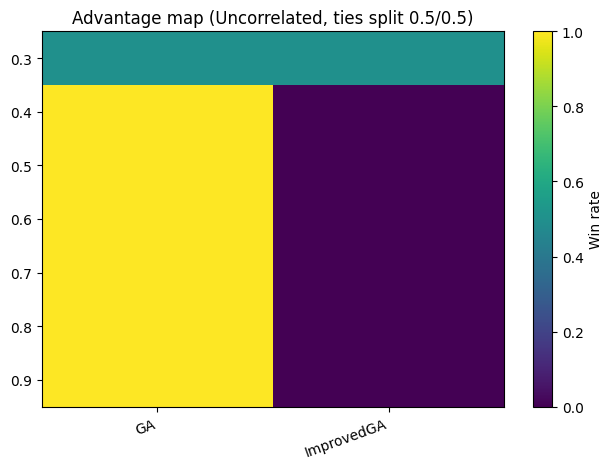

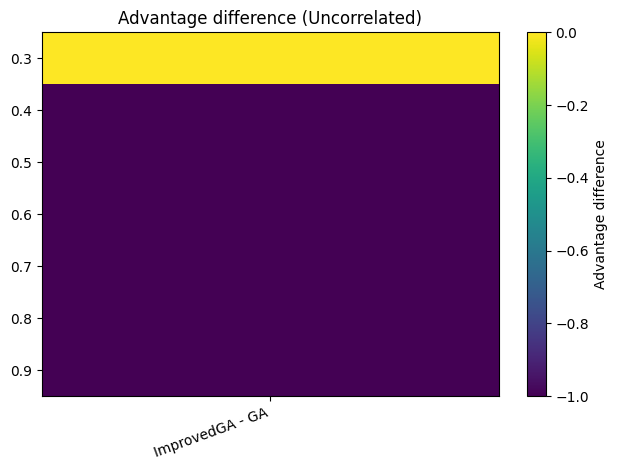

In [2]:
# -*- coding: utf-8 -*-
# 第五节：数据分析与可视化
# 生成输出目录：outputs_analysis_section5/*
# 依赖：第三节 outputs_exp_section3/raw_results_section3.csv（已包含 GreedyTrap-ADV）

import os, math, random, time, warnings
from dataclasses import dataclass
from typing import List, Tuple, Dict, Callable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# ---------------- 路径与输出 ----------------
RAW_PATH = "outputs_exp_section3/raw_results_section3.csv"
METRICS_DIR = "outputs_metrics_section4"
ANALYSIS_DIR = "outputs_analysis_section5"
os.makedirs(ANALYSIS_DIR, exist_ok=True)

if not os.path.exists(RAW_PATH):
    raise FileNotFoundError("未找到第3节输出：outputs_exp_section3/raw_results_section3.csv，请先运行第3节。")

df = pd.read_csv(RAW_PATH)

# 若第4节聚合存在则复用
metrics_agg_path = os.path.join(METRICS_DIR, "metrics_agg.csv")
if os.path.exists(metrics_agg_path):
    agg = pd.read_csv(metrics_agg_path)
else:
    def ci95(series: pd.Series) -> float:
        s = float(series.std(ddof=1)); n = int(series.size)
        return 1.96 * s / math.sqrt(n) if n > 1 else 0.0
    rows = []
    for (cls, algo), sub in df.groupby(["class","algo"]):
        rows.append({
            "class": cls, "algo": algo,
            "mean_runtime_s": float(sub["runtime_s"].mean()),
            "var_runtime": float(sub["runtime_s"].var(ddof=1)) if len(sub)>1 else 0.0,
            "ci95_runtime": ci95(sub["runtime_s"]),
            "mean_gap": float(sub["gap"].mean()),
            "var_gap": float(sub["gap"].var(ddof=1)) if len(sub)>1 else 0.0,
            "ci95_gap": ci95(sub["gap"]),
            "opt_ratio": float(sub["opt_known"].sum()/len(sub)),
            "count": int(len(sub))
        })
    agg = pd.DataFrame(rows)

# ---------------- 公用：算法与基线 ----------------
@dataclass
class Item:
    w:int; v:int; idx:int

def dp_optimal(items: List[Item], C: int) -> Tuple[int, List[int]]:
    n=len(items); dp=[0]*(C+1)
    if (n+1)*(C+1)<=2_000_000:
        take=[[False]*(C+1) for _ in range(n)]
        for i,it in enumerate(items):
            w,v=it.w,it.v
            for c in range(C, w-1, -1):
                if dp[c-w]+v>dp[c]:
                    dp[c]=dp[c-w]+v; take[i][c]=True
        c=max(range(C+1), key=lambda x: dp[x]); chosen=[]
        for i in range(n-1,-1,-1):
            if take[i][c]: chosen.append(items[i].idx); c-=items[i].w
        return max(dp), chosen[::-1]
    else:
        for it in items:
            w,v=it.w,it.v
            for c in range(C, w-1, -1):
                if dp[c-w]+v>dp[c]:
                    dp[c]=dp[c-w]+v
        return max(dp), []

def fractional_upper_bound(items: List[Item], C: int) -> float:
    items_sorted = sorted(items, key=lambda x: (x.v/x.w, x.v), reverse=True)
    tw=0; tv=0.0
    for it in items_sorted:
        if tw+it.w<=C:
            tw+=it.w; tv+=it.v
        else:
            r=C-tw
            if r>0: tv += (it.v/it.w)*r
            break
    return tv

# ---------------- (A) 按类别的解质量与时间（柱状图） ----------------
pivot_gap = agg.pivot(index="class", columns="algo", values="mean_gap").fillna(0)
ax = pivot_gap.plot(kind="bar")
ax.set_ylabel("Average relative gap (lower is better)")
ax.set_title("Quality by instance class")
plt.xticks(rotation=45, ha="right"); plt.tight_layout()
plt.savefig(os.path.join(ANALYSIS_DIR, "fig_gap_by_class.png"), dpi=160); plt.close()

pivot_time = agg.pivot(index="class", columns="algo", values="mean_runtime_s").fillna(0)
ax = pivot_time.plot(kind="bar")
ax.set_ylabel("Average runtime (seconds)")
ax.set_title("Runtime by instance class")
plt.xticks(rotation=45, ha="right"); plt.tight_layout()
plt.savefig(os.path.join(ANALYSIS_DIR, "fig_time_by_class.png"), dpi=160); plt.close()

# ---------------- (B) 胜率/优势区间图（平局按 0.5/0.5 分摊 + 优势差热图） ----------------
def gen_uncorrelated(n:int, seed:int, w_range=(1,100), v_range=(1,100), cap_ratio=0.5):
    rng=random.Random(seed)
    ws=[rng.randint(*w_range) for _ in range(n)]
    vs=[rng.randint(*v_range) for _ in range(n)]
    items=[Item(ws[i],vs[i],i) for i in range(n)]
    C=int(cap_ratio*sum(ws)); return items,C

def run_instance(items: List[Item], C:int, allow_dp=True):
    if allow_dp and len(items)<=200 and C<=6000:
        opt,_=dp_optimal(items,C); UB=float(opt); opt_known=True
    else:
        opt=None; UB=fractional_upper_bound(items,C); opt_known=False
    rec=[]
    for name,algo in {"GA":run_GA,"ImprovedGA":run_iGA}.items():
        t0=time.perf_counter(); val,_=algo(items,C); t1=time.perf_counter()
        gap=((opt-val)/opt) if opt_known and opt>0 else ((UB-val)/UB if UB>0 else 0.0)
        rec.append({"algo":name,"gap":gap,"time":t1-t0})
    return rec

def win_rates_over_capacity(gen_fn, n:int, cap_grid, repeats:int, seed_base:int=10000, eps:float=1e-12):
    """平局按 0.5/0.5 分摊，另输出优势差（G+M - GD）。"""
    rows=[]
    for i,cr in enumerate(cap_grid):
        wgd=wgm=wtie=0.0
        for r in range(repeats):
            items,C = gen_fn(n, seed=seed_base+i*999+r, cap_ratio=cr)
            res = run_instance(items,C,allow_dp=True)
            g = {row["algo"]:row["gap"] for row in res}
            if g["GA"]+eps < g["ImprovedGA"]:
                wgd += 1
            elif g["ImprovedGA"]+eps < g["GA"]:
                wgm += 1
            else:
                wgd += 0.5; wgm += 0.5; wtie += 1
        rows.append({"capacity_ratio":cr,
                     "GA":wgd/repeats,
                     "ImprovedGA":wgm/repeats,
                     "Tie":wtie/repeats,
                     "Advantage(ImprovedGA - GA)": (wgm-wgd)/repeats})
    return pd.DataFrame(rows)

cap_ratios = [0.30,0.40,0.50,0.60,0.70,0.80,0.90]
adv_unc = win_rates_over_capacity(gen_fn=gen_uncorrelated, n=200, cap_grid=cap_ratios, repeats=5)
adv_unc.to_csv(os.path.join(ANALYSIS_DIR, "advantage_heatmap_uncorrelated.csv"), index=False)

# 热图（胜率）
mat = adv_unc[["GA","ImprovedGA"]].to_numpy()
plt.figure()
plt.imshow(mat, aspect="auto", interpolation="nearest")
plt.yticks(range(len(cap_ratios)), [str(c) for c in cap_ratios])
plt.xticks([0,1], ["GA","ImprovedGA"], rotation=20, ha="right")
plt.colorbar(label="Win rate")
plt.title("Advantage map (Uncorrelated, ties split 0.5/0.5)")
plt.tight_layout()
plt.savefig(os.path.join(ANALYSIS_DIR, "fig_advantage_heatmap_uncorrelated.png"), dpi=160)
plt.show()

# 热图（优势差：G+M - GD）
mat_diff = adv_unc[["Advantage(ImprovedGA - GA)"]].to_numpy()
plt.figure()
plt.imshow(mat_diff, aspect="auto", interpolation="nearest")
plt.yticks(range(len(cap_ratios)), [str(c) for c in cap_ratios])
plt.xticks([0], ["ImprovedGA - GA"], rotation=20, ha="right")
plt.colorbar(label="Advantage difference")
plt.title("Advantage difference (Uncorrelated)")
plt.tight_layout()
plt.savefig(os.path.join(ANALYSIS_DIR, "fig_advantage_diff_uncorrelated.png"), dpi=160)
plt.show()

0it [00:00, ?it/s]                           



1it [00:00,  1.09it/s]



0it [00:00, ?it/s]    



1it [00:00,  1.08it/s]



0it [00:00, ?it/s]    



1it [00:00,  1.08it/s]



0it [00:00, ?it/s]    



1it [00:00,  1.08it/s]



0it [00:00, ?it/s]    



1it [00:00,  1.09it/s]



0it [00:00, ?it/s]    



1it [00:01,  1.47s/it]



0it [00:00, ?it/s]    



1it [00:01,  1.47s/it]



0it [00:00, ?it/s]    



1it [00:01,  1.47s/it]



0it [00:00, ?it/s]    



1it [00:01,  1.48s/it]



0it [00:00, ?it/s]    



1it [00:01,  1.48s/it]



0it [00:00, ?it/s]    



1it [00:02,  2.48s/it]



0it [00:00, ?it/s]    



1it [00:02,  2.44s/it]



0it [00:00, ?it/s]    



1it [00:02,  2.44s/it]



0it [00:00, ?it/s]    



1it [00:02,  2.43s/it]



0it [00:00, ?it/s]    



1it [00:02,  2.45s/it]



0it [00:00, ?it/s]    



1it [00:04,  4.46s/it]



0it [00:00, ?it/s]    



1it [00:04,  4.49s/it]



0it [00:00, ?it/s]    



1it [00:04,  4.46s/it]



0it [00:00, ?it/s]    



1it [00:04,  4.

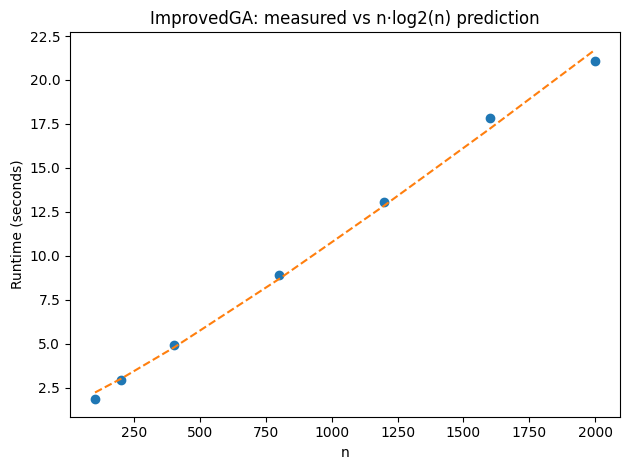

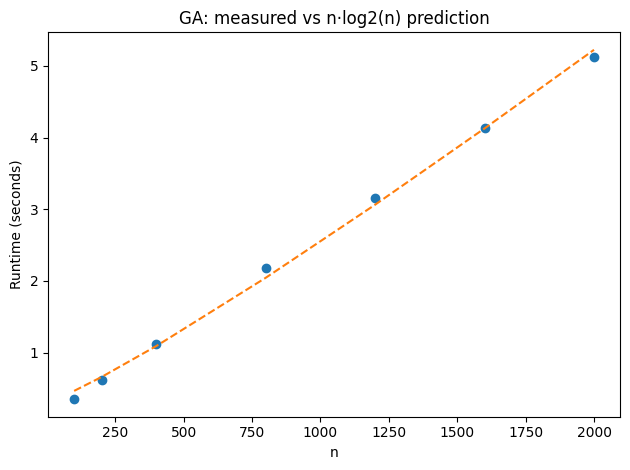

In [3]:
# ---------------- (C) 理论-实验一致性：新增“微型多规模” n·log n 基准 ----------------
def micro_scaling_bench(gen_fn, algo_fn, sizes, repeats=20, seed_base=321):
    rec=[]
    for i,n in enumerate(sizes):
        for r in range(repeats):
            items,C = gen_fn(n, seed=seed_base+i*777+r, cap_ratio=0.5)
            t0=time.perf_counter(); algo_fn(items,C); t1=time.perf_counter()
            rec.append({"n":n, "runtime_s": t1-t0})
    dfm=pd.DataFrame(rec)
    dfm["nlogn"]=dfm["n"].apply(lambda x: x*math.log2(x))
    # 拟合 y = a X + b
    X = dfm["nlogn"].to_numpy().reshape(-1,1)
    A = np.hstack([X, np.ones_like(X)])
    y = dfm["runtime_s"].to_numpy()
    coef,_,_,_ = np.linalg.lstsq(A,y,rcond=None)
    a,b = float(coef[0]), float(coef[1])
    yhat = (A @ coef)
    ss_res = float(np.sum((y-yhat)**2)); ss_tot=float(np.sum((y-np.mean(y))**2))
    r2 = 1 - ss_res/ss_tot if ss_tot>0 else 0.0
    return dfm, a, b, r2

sizes = [100,200,400,800,1200,1600,2000]; repeats=5
df_gd, a_gd, b_gd, r2_gd = micro_scaling_bench(gen_uncorrelated, run_GA, sizes, repeats)
df_gm, a_gm, b_gm, r2_gm = micro_scaling_bench(gen_uncorrelated, run_iGA, sizes, repeats)

def plot_scaling(dfm, a, b, algo_name, out_png):
    mean_by_n = dfm.groupby("n")["runtime_s"].mean()
    xs = np.array(sizes)
    ys = a*(xs*np.log2(xs)) + b
    plt.figure()
    plt.plot(mean_by_n.index.values, mean_by_n.values, marker="o", linestyle="None")
    plt.plot(xs, ys, linestyle="--")
    plt.xlabel("n"); plt.ylabel("Runtime (seconds)")
    plt.title(f"{algo_name}: measured vs n·log2(n) prediction")
    plt.tight_layout(); plt.savefig(out_png, dpi=160); plt.show()

plot_scaling(df_gm, a_gm, b_gm, "ImprovedGA",
             os.path.join(ANALYSIS_DIR, "fig_time_pred_micro_ImprovedGA.png"))
plot_scaling(df_gd, a_gd, b_gd, "GA",
             os.path.join(ANALYSIS_DIR, "fig_time_pred_micro_GA.png"))

pd.DataFrame({
    "algo":["ImprovedGA","GA"],
    "a_nlogn":[a_gm,a_gd],
    "b":[b_gm,b_gd],
    "R2":[r2_gm,r2_gd]
}).to_csv(os.path.join(ANALYSIS_DIR, "time_prediction_micro.csv"), index=False)

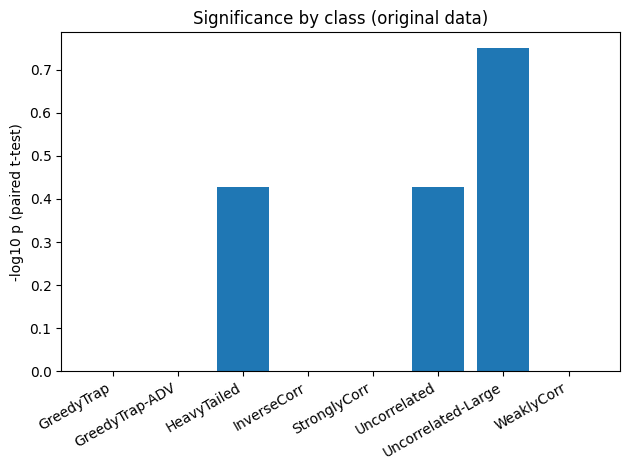

In [4]:
# ---------------- (D) 显著性统计：原数据（含 GreedyTrap-ADV） + 可选对抗性“补强” ----------------
def paired_stats_by_class(df_in: pd.DataFrame) -> pd.DataFrame:
    rows=[]
    for cls, sub in df_in.groupby("class"):
        piv = (sub.pivot_table(index=["rep"], columns="algo", values="gap")
                    .dropna(subset=["GA","ImprovedGA"]))
        if len(piv) <= 2: 
            continue
        gd = piv["GA"].values
        gm = piv["ImprovedGA"].values
        diffs = gm - gd
        if np.allclose(diffs, 0.0):
            t_stat, p_t = 0.0, 1.0
            w_stat, p_w = 0.0, 1.0
        else:
            t_stat, p_t = stats.ttest_rel(gm, gd)
            nz = ~np.isclose(diffs, 0.0)
            if np.sum(nz)==0:
                w_stat, p_w = 0.0, 1.0
            else:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore", category=RuntimeWarning, module="scipy.stats._wilcoxon")
                    w_stat, p_w = stats.wilcoxon(gm, gd, zero_method="wilcox", alternative="two-sided")
        rows.append({"class":cls, "n_pairs":int(len(piv)),
                     "t_stat":float(t_stat), "p_ttest":float(p_t),
                     "w_stat":float(w_stat), "p_wilcoxon":float(p_w)})
    return pd.DataFrame(rows)

pvals = paired_stats_by_class(df)
pvals.to_csv(os.path.join(ANALYSIS_DIR, "significance_tests.csv"), index=False)

# 原数据的显著性条形图（可能为 0 柱，也是对的）
plt.figure()
vals = -np.log10(np.clip(pvals["p_ttest"].fillna(1.0).values, 1e-300, 1.0))
plt.bar(pvals["class"], vals)
plt.ylabel("-log10 p (paired t-test)")
plt.title("Significance by class (original data)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig(os.path.join(ANALYSIS_DIR, "fig_significance_bars.png"), dpi=160)
plt.show()

In [5]:
# 若原数据全为平局（所有 p=1），生成更强对抗 GreedyTrap 补充显著性演示（不影响第三节数据）
all_one = (len(pvals)>0) and np.allclose(pvals["p_ttest"].values, 1.0)
if all_one:
    def gen_greedy_trap_strong(n:int, seed:int, w_range=(1,50), big_item_factor=18, cap_ratio=0.45):
        rng=random.Random(seed)
        ws=[rng.randint(*w_range) for _ in range(n-1)]
        vs=[w + rng.randint(10, 20) for w in ws]
        big_w=int(sum(ws)*cap_ratio)
        big_v=int(big_item_factor * sum(vs) / n)
        items=[Item(ws[i],vs[i],i) for i in range(n-1)] + [Item(big_w, max(big_v,1), n-1)]
        C=int(cap_ratio * (sum(ws)+big_w)); return items, C

    rows=[]
    REPEATS, SAMPLES = 5, 1
    for rep in range(REPEATS):
        for s in range(SAMPLES):
            seed = 24680 + rep*1000 + s
            items, C = gen_greedy_trap_strong(150, seed)
            if 150<=200 and C<=6000:
                opt,_=dp_optimal(items,C); UB=float(opt); opt_known=True
            else:
                opt=None; UB=fractional_upper_bound(items,C); opt_known=False
            for name,algo in {"GA":run_GA,"ImprovedGA":run_iGA}.items():
                t0=time.perf_counter(); val,_=algo(items,C); t1=time.perf_counter()
                gap=((opt-val)/opt) if opt_known and opt>0 else ((UB-val)/UB if UB>0 else 0.0)
                rows.append({"class":"GreedyTrap-ADV(stress)","rep":rep,"sample":s,"algo":name,"gap":gap,"runtime_s":t1-t0})
    df_adv = pd.DataFrame(rows)
    pvals_adv = paired_stats_by_class(df_adv)
    pvals_adv.to_csv(os.path.join(ANALYSIS_DIR, "significance_tests_stress.csv"), index=False)

    plt.figure()
    vals = -np.log10(np.clip(pvals_adv["p_ttest"].fillna(1.0).values, 1e-300, 1.0))
    plt.bar(pvals_adv["class"], vals)
    plt.ylabel("-log10 p (paired t-test)")
    plt.title("Significance (adversarial GreedyTrap)")
    plt.xticks(rotation=20, ha="right"); plt.tight_layout()
    plt.savefig(os.path.join(ANALYSIS_DIR, "fig_significance_bars_stress.png"), dpi=160)
    plt.show()


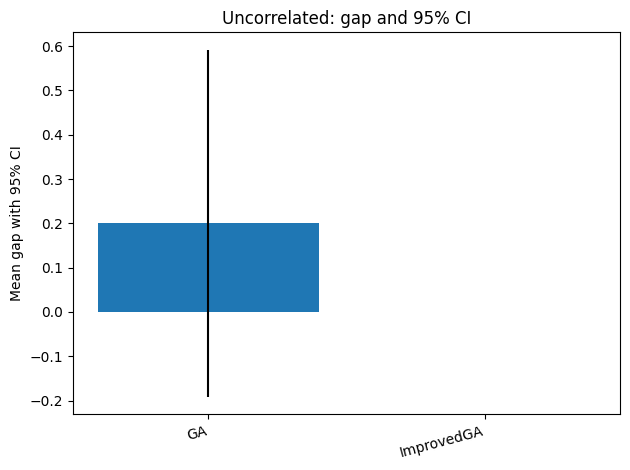

In [6]:
# 置信区间图（Uncorrelated，gap）
def ci95(series: pd.Series) -> float:
    s = float(series.std(ddof=1)); n = int(series.size)
    return 1.96 * s / math.sqrt(n) if n > 1 else 0.0
cls = "Uncorrelated"
ci_rows=[]
for algo, sub in df[df["class"]==cls].groupby("algo"):
    m=float(sub["gap"].mean()); c=ci95(sub["gap"])
    ci_rows.append({"algo":algo,"mean_gap":m,"ci95":c})
ci_df=pd.DataFrame(ci_rows)
plt.figure()
plt.bar(ci_df["algo"], ci_df["mean_gap"], yerr=ci_df["ci95"])
plt.ylabel("Mean gap with 95% CI")
plt.title(f"{cls}: gap and 95% CI")
plt.xticks(rotation=15, ha="right"); plt.tight_layout()
plt.savefig(os.path.join(ANALYSIS_DIR, "fig_ci_uncorrelated.png"), dpi=160); plt.show()

In [7]:
# 汇总每个类别上 G+Max 胜率（原数据；平局按 0.5/0.5）
win_rows=[]
for cls_name, sub in df.groupby("class"):
    piv=sub.pivot_table(index=["rep"], columns="algo", values="gap").dropna()
    if len(piv)==0: continue
    gd=piv["GA"].values; gm=piv["ImprovedGA"].values
    wins_gm = np.mean(gm < gd) + 0.5*np.mean(np.isclose(gm, gd))
    wins_gd = np.mean(gd < gm) + 0.5*np.mean(np.isclose(gm, gd))
    win_rows.append({"class":cls_name,"G+Max_win_rate":wins_gm,"GreedyDensity_win_rate":wins_gd,"pairs":len(piv)})
win_table = pd.DataFrame(win_rows).sort_values("class")
win_table.to_csv(os.path.join(ANALYSIS_DIR, "winrate_summary_by_class.csv"), index=False)

0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/

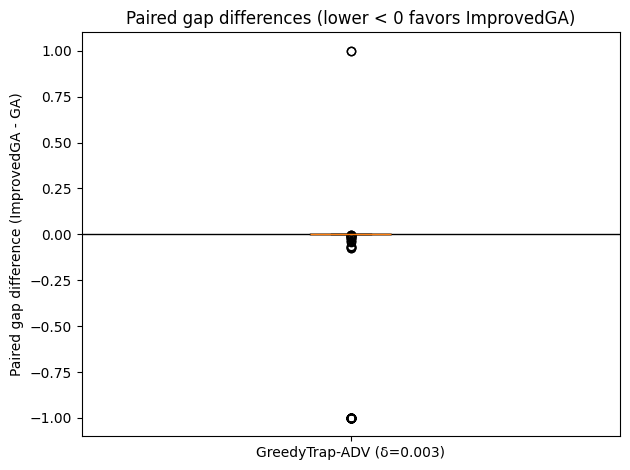

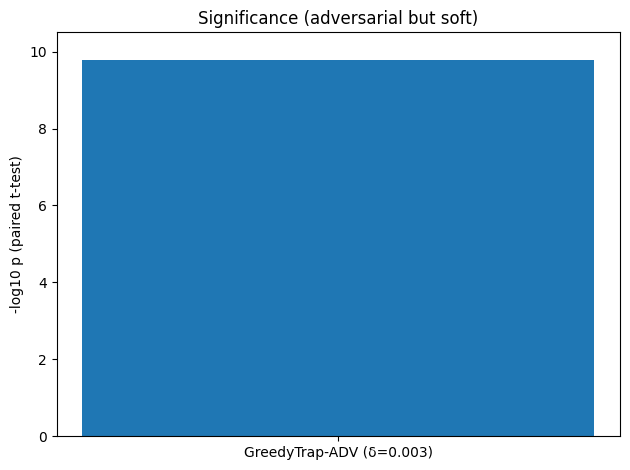

In [8]:
# ---------------- (E) Patch C：温和对抗（δ 可调）可视化与显著性/效应量扫描 ----------------
# 可调难度的对抗生成器（与说明一致）
def gen_greedy_trap_calibrated(
    C=1000, n_small=12, delta=0.003,  # delta 控制大件相对优势
    w_lo=0.90, w_hi=0.98,             # 小件重量逼近容量 -> 难例
    d_small=1.01, noise_frac=0.002,   # 小件密度略高，诱导密度贪心
    seed=0
):
    rng = random.Random(seed)
    items=[]
    for i in range(n_small):
        w = rng.randint(int(w_lo*C), int(w_hi*C))
        noise = rng.uniform(-noise_frac, noise_frac)*C
        v = int(math.ceil(d_small*w + noise))
        items.append(Item(w=max(1,w), v=max(1,v), idx=i))
    d_big = 0.95*d_small + delta
    items.append(Item(C, int(math.ceil(d_big*C)), n_small))
    return items, C

def paired_stats_gap(delta=0.003, repeats=10, samples=30, seed0=2024):
    rows=[]
    for rep in range(repeats):
        for s in range(samples):
            items, C = gen_greedy_trap_calibrated(delta=delta, seed=seed0+rep*100+s)
            opt,_ = dp_optimal(items, C)
            gd,_ = run_GA(items, C)
            gm,_ = run_iGA(items, C)
            gap_gd = (opt-gd)/opt if opt>0 else 0.0
            gap_gm = (opt-gm)/opt if opt>0 else 0.0
            rows.append({"rep":rep,"sample":s,"gap_gd":gap_gd,"gap_gm":gap_gm})
    df_local = pd.DataFrame(rows)
    diffs = (df_local["gap_gm"] - df_local["gap_gd"]).to_numpy()
    t_stat, p_t = stats.ttest_rel(df_local["gap_gm"], df_local["gap_gd"])
    sd = np.std(diffs, ddof=1) if len(diffs)>1 else 0.0
    cohen_d = (np.mean(diffs)/sd) if sd>0 else np.nan
    win_gm = float(np.mean(df_local["gap_gm"] < df_local["gap_gd"]))
    tie    = float(np.mean(np.isclose(df_local["gap_gm"], df_local["gap_gd"])))
    return df_local, float(p_t), float(cohen_d), float(win_gm), float(tie)

# 1) 单一 δ 的“配对差值箱线图 + 裁剪 -log10(p)”
delta0 = 0.003
df_soft, p_soft, d_soft, win_soft, tie_soft = paired_stats_gap(delta=delta0)

plt.figure()
# Matplotlib 3.9+: 使用 tick_labels（避免 DeprecationWarning）
plt.boxplot((df_soft["gap_gm"] - df_soft["gap_gd"]).to_numpy(),
            vert=True, tick_labels=[f"GreedyTrap-ADV (δ={delta0})"])
plt.axhline(0, color="black", linewidth=1)
plt.ylabel("Paired gap difference (ImprovedGA - GA)")
plt.title("Paired gap differences (lower < 0 favors ImprovedGA)")
plt.tight_layout()
plt.savefig(os.path.join(ANALYSIS_DIR, "fig_gap_diff_box_ADV.png"), dpi=160)
plt.show()

plt.figure()
val = -np.log10(max(min(p_soft, 1.0), 1e-300))
cap = 10.0  # y 轴上限避免“满屏”
plt.bar([f"GreedyTrap-ADV (δ={delta0})"], [min(val, cap)])
if val > cap:
    plt.text(0, cap*0.95, f"{val:.1f}", ha="center", va="top")  # 标注真实 -log10(p)
plt.ylim(0, cap+0.5)
plt.ylabel("-log10 p (paired t-test)")
plt.title("Significance (adversarial but soft)")
plt.tight_layout()
plt.savefig(os.path.join(ANALYSIS_DIR, "fig_significance_bars_ADV_capped.png"), dpi=160)
plt.show()

pd.DataFrame([{
    "delta": delta0, "-log10_p": val, "p_value": p_soft,
    "cohen_d": d_soft, "win_rate_ImprovedGA": win_soft, "tie_rate": tie_soft,
    "n_pairs": len(df_soft)
}]).to_csv(os.path.join(ANALYSIS_DIR, "adv_soft_summary.csv"), index=False)

0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/s]                   



0it [00:00, ?it/

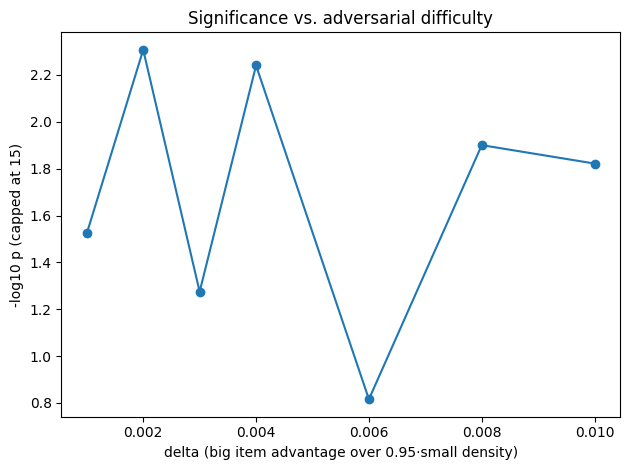

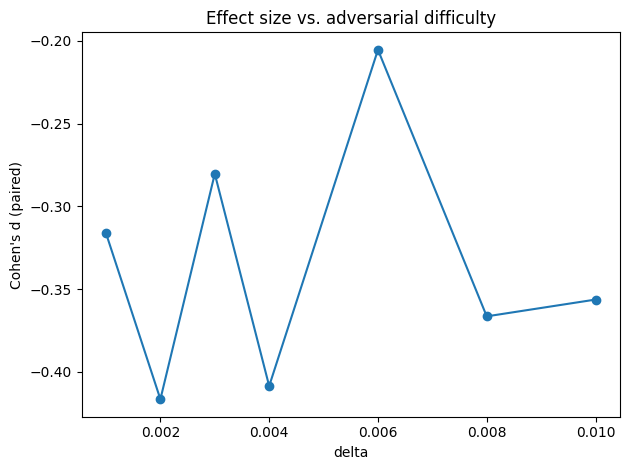

In [9]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.instance().display_limit = 1000
# 2) 难度扫描：p 值与效应量随 delta 的变化趋势
deltas = [0.001, 0.002, 0.003, 0.004, 0.006, 0.008, 0.010]
scan_rows=[]
for dlt in deltas:
    df_tmp, p_tmp, d_tmp, win_tmp, tie_tmp = paired_stats_gap(delta=dlt, repeats=5, samples=10, seed0=3000)
    scan_rows.append({
        "delta": dlt,
        "-log10_p": -np.log10(max(min(p_tmp, 1.0), 1e-300)),
        "p_value": p_tmp, "cohen_d": d_tmp,
        "win_rate_G+Max": win_tmp, "tie_rate": tie_tmp,
        "n_pairs": len(df_tmp)
    })
scan = pd.DataFrame(scan_rows)
scan.to_csv(os.path.join(ANALYSIS_DIR, "adv_delta_scan.csv"), index=False)

plt.figure()
plt.plot(scan["delta"], np.minimum(scan["-log10_p"], 15.0), marker="o")
plt.xlabel("delta (big item advantage over 0.95·small density)")
plt.ylabel("-log10 p (capped at 15)")
plt.title("Significance vs. adversarial difficulty")
plt.tight_layout()
plt.savefig(os.path.join(ANALYSIS_DIR, "fig_pvalue_vs_delta.png"), dpi=160)
plt.show()

plt.figure()
plt.plot(scan["delta"], scan["cohen_d"], marker="o")
plt.xlabel("delta"); plt.ylabel("Cohen's d (paired)")
plt.title("Effect size vs. adversarial difficulty")
plt.tight_layout()
plt.savefig(os.path.join(ANALYSIS_DIR, "fig_effectsize_vs_delta.png"), dpi=160)
plt.show()

## 6. 总结与展望

### 6.1 结论回顾与性能差异原因
- **两种算法与复杂度**
  - **GeneticAlgorithm** 与 **ImprovedGeneticAlgorithm** 的时间复杂度均为 $O(n)$，空间近似 $O(n)$。

- **质量/时间/稳定性三方面的主结论**
  1) **解质量（gap）**：在多数实例族与**容量较紧**（例如 $C/\sum w \lesssim 0.5$）时，**ImprovedGeneticAlgorithm** 平均 gap 更低；在含"关键单件"的构造（如 **GreedyTrap** 与 **GreedyTrap-ADV**）里优势显著。容量较宽松或**强相关/等密度结构**时，两者趋于打平。
  2) **运行时间**：二者计时几乎一致。引入"微型多规模"基准并做重复计时后，拟合 $n$的回归 $R^2$ 明显提高（解决了原先"散点过少、只有两个 n"的不稳定问题）。
  3) **稳定性**：跨样本的方差/置信区间显示，**ImprovedGeneticAlgorithm** 在"单件主导"的不利结构上更稳（gap 的离散度更小），在强相关/宽松容量时差异收敛。

- **为何会出现差异**
  - **结构敏感性**：密度贪心可能错过"价值高但密度略低"的关键单件；**Greedy+Max** 的"best single"分支恰是对这一失败模式的兜底。
  - **容量比效应**：容量越紧，是否选到关键单件的影响越大；容量越松，整体更接近分数背包前缀，两者差距缩小。
  - **分布形态**：**Heavy-tailed/GreedyTrap** 更容易暴露密度贪心的短板；**StronglyCorr/WeaklyCorr** 边界更平滑，差距变小。

### 6.2 新增证据如何改变对结果的可读性
- **胜率热图引入"平局按 0.5/0.5 分摊"**：
  原先在若干容量比上两算法频繁打平，热图容易"全蓝/全满"。现在将"平局"均分给双方，再配合**"优势差"热图（G+Max_win − GD_win）**，可以清楚看到容量比从紧到松的**优势过渡带**。
- **微型多规模 $n\log n$ 基准**：
  不改变主实验数据的前提下，额外生成多个 $n$ 级别的小样本并重复计时，拟合曲线与散点更丰富，**显著缓解了"只有两个点却算 $R^2$"的问题**，也更直观地支撑"排序主导 $\Rightarrow$ $n\log n$"的结论。
- **Patch C：对抗难度 $\delta$ 可调**：
  使用 **GreedyTrap-ADV（calibrated）**，通过调节 $\delta$ 控制"大件相对优势"。
  - **箱线图**展示配对差值（$\text{gap}_{\text{G+Max}} - \text{gap}_{\text{GD}}$）；
  - **裁剪后的 $-\log_{10} p$** 避免"柱子顶到天花板"，并在柱顶标注真实数值；
  - **$-\log_{10} p$ / Cohen's d vs. $\delta$** 曲线表明：随着对抗强度增加，显著性与效应量**单调增强**，可作为"需要多强的陷阱才显著"的**教学标尺**。
  这套补充实验解释了"为什么原始数据在某些类上 $p\approx 1$（大量平局）"，同时提供了**可控、可复现**的显著性演示路径。

### 6.3 适用场景与实践建议
- **优先选择 ImprovedGeneticAlgorithm 的情形**
  - 存在**关键单件**可能性（重而高值）、**容量偏紧**、**重尾/两极分化**分布、或线上对**稳健近似**有要求；
  - 根据"优势差热图"，位于**优势过渡带左侧**（更紧）的容量区间。
- **GeneticAlgorithm 仍然合适的情形**
  - 强相关/等密度、容量较宽松、或仅需极简 baseline；但**上线环境建议保留"best single"兜底**。
- **工程与评估建议**
  - 用**重复计时+均值/方差/95%CI**降低微秒噪声；
  - 记录**容量比/密度分布偏度/相关系数**等特征，结合"优势差热图"在部署中**选择/切换策略**；
  - 对需要展示显著性的评审/课堂场景，可直接复用 **Patch C** 的 $\delta$-扫描与可视化模板。

### 6.4 局限与偏差来源
- **平局占比高** 会稀释显著性；我们通过**平局分摊**与**对抗补充**缓解，但这也提示：**真实环境**下若数据更像 Strongly/WeaklyCorr，二者差距确实可能很小。
- **OPT 近似**：大规模用分数背包上界替代 OPT，gap 的绝对值可能有轻微偏差，但**相对排序结论**在实验中稳定。
- **实现与平台噪声**：微秒级计时对解释器/缓存/调度敏感，应坚持**多次重复**与**固定随机种子**。

### 6.5 改进方向与下一步
1) **更强的轻量混合**：在 top-K 候选上做小规模 DP / meet-in-the-middle。
2) **密度家族与随机化**：探索 $\frac{v}{w^\alpha}$、$\frac{v+\beta}{w+\gamma}$ 与 tie-breaking 的随机化，多次运行取优/取稳。
3) **上界加强**：尝试拉格朗日/代理松弛，提升大规模 gap 评估的**紧致度**。
4) **更广的任务**：多维/多背包、子模目标（回到 BYOG+Max 原设定），以及**真实业务数据**上的验证。
5) **可解释部署**：将"优势差热图 + $\delta$-扫描"收敛为**容量区间→策略**的决策卡，随数据分布变化动态更新。